# 1. Środowisko eksperymentalne

Niniejszy notebook implementuje eksperyment badawczy, dotyczący detekcji anomalii w ruchu sieciowym z wykorzystaniem zbioru danych CIC-IDS-2017 oraz algorytmów nienadzorowanego uczenia maszynowego.

### Import Bibliotek

Na początku importujemy wszystkie niezbędne biblioteki. Będziemy korzystać z `pandas` do manipulacji danymi, `numpy` do operacji numerycznych, `scikit-learn` do modeli uczenia maszynowego, preprocessingu i metryk, `tensorflow/keras` do budowy autoenkodera oraz `matplotlib` i `seaborn` do wizualizacji. 

In [1]:
import sklearn
print(sklearn.__version__)

1.8.0


In [2]:
# from thundersvm import OneClassSVM
from sklearn.svm import OneClassSVM

In [3]:
import pandas as pd
import numpy as np
import glob
import os
import time

# Trening i modele
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.base import BaseEstimator, clone
from sklearn.decomposition import PCA
from itertools import product
import random

# Dla Autoenkodera (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Metryki
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Testy statystyczne
from scipy.stats import shapiro, levene, friedmanchisquare
import scikit_posthocs as sp

# Wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia dla czytelności
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Ustawienie ziarna losowości dla powtarzalności
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print(f"TensorFlow version: {tf.__version__}")

s:\PWR\PNW\PNW2\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0


In [4]:
print(type(OneClassSVM()))

<class 'sklearn.svm._classes.OneClassSVM'>


In [5]:
os.getcwd()

's:\\PWR\\PNW\\PNW2\\analytic_pipline'

## 1.1 Preprocessing danych

W tej sekcji zajmiemy się przygotowaniem danych CIC-IDS-2017 do treningu modeli.

### 1. Wczytanie i połączenie danych

Pliki CSV składające się na zbiór CIC-IDS-2017 zostaną wczytane i połączone w jeden spójny zbiór danych.

In [ ]:
DATA_PATH = './MachineLearningCVE/'

all_files = glob.glob(os.path.join(DATA_PATH, "*.csv"))
df_list = []
for filename in all_files:
    df_file = pd.read_csv(filename, low_memory=False)
    df_list.append(df_file)
    print(f"Wczytano: {filename}, kształt: {df_file.shape}")

df_raw = pd.concat(df_list, ignore_index=True)
print(f"\nPołączony zbiór danych ma kształt: {df_raw.shape}")
print(df_raw.head())

Wczytaj gotowe, połaczne dane 

In [6]:
df_cleaned = pd.read_csv('./MachineLearningCVE/cleaned_dataset.csv', low_memory=False)

In [7]:
display(df_cleaned)

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2520793                 53           32215                   4   
2520794                 53             324                   2   
2520795              58030              82                   2   
2520796                 53         1048635                   6   
2520797                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2520793                        2                          112   
2520794                        2                           84   
2520795                        1                           31   
2520796                        2                          192   
2520797                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2520793                           152                      28   
2520794                           362                      42   
2520795                             6                      31   
2520796                           256                      32   
2520797                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2520793                      28                     28.0   
2520794                      42                     42.0   
2520795                       0                     15.5   
2520796                      32                     32.0   
2520797                      47                     47.0   

          Fwd Packet Length Std  Bwd Packet Length Max  \
0                      0.000000                      0   
1                      0.000000                      6   
2                      0.000000                      6   
3                      0.000000                      6   
4                      0.000000                      0   
...                         ...                    ...   
2520793                0.000000                     76   
2520794                0.000000                    181   
2520795               21.920311                      6   
2520796                0.000000                    128   
2520797                0.000000                    113   

          Bwd Packet Length Min   Bwd Packet Length Mean  \
0                             0                      0.0   
1                             6                      6.0   
2                             6                      6.0 

### wersja z jedną .csv - DO MNIEJSZYCH TESTÓW !!!

In [ ]:
filename = './MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv'

df_raw = pd.read_csv(filename, low_memory=False)
print(f"Wczytano: {filename}, kształt: {df_raw.shape}")
df_raw.head()

In [6]:
print("Czy spacje są na początku nazw kolumn?", df_raw.columns.str.startswith(' ').any())
print("Czy spacje są na końcu nazw kolumn?", df_raw.columns.str.endswith(' ').any())
df_raw.columns = df_raw.columns.str.strip()
print("Nazwy kolumn po usunięciu spacji:", df_raw.columns.tolist())

Czy spacje są na początku nazw kolumn? True
Czy spacje są na końcu nazw kolumn? False
Nazwy kolumn po usunięciu spacji: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SY

### 2. Czyszczenie danych

Proces czyszczenia obejmuje:
- Usunięcie wierszy zawierających brakujące wartości (NaN) lub wartości nieskończone (Infinity).
- Usunięcie zduplikowanych rekordów.

In [31]:
label_column_name = ' Label'
df_cleaned = df_raw.copy()

# Sprawdźmy czy występują wartości nieskończone (inf)
count = df_cleaned[df_cleaned == np.inf].count()
for col in df_cleaned.columns:
    if count[col] > 0:
        print(f"Kolumna {col} zawiera {count[col]} nieskończoności (inf)")

Kolumna Flow Bytes/s zawiera 1509 nieskończoności (inf)
Kolumna  Flow Packets/s zawiera 2867 nieskończoności (inf)


In [32]:
print("Kształt przed czyszczeniem:", df_cleaned.shape)

# Usuwanie wierszy z NaN lub Inf
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
before_drop = df_cleaned.shape[0]
df_cleaned.dropna(inplace=True)
print(f"Liczba usuniętych wierszy: {before_drop - df_cleaned.shape[0]}")
print(f"Liczba wierszy po usunięciu NaN: {df_cleaned.shape[0]}")

# Usuwanie zduplikowanych rekordów
before_drop = df_cleaned.shape[0]
df_cleaned.drop_duplicates(inplace=True)
print(f"Liczba usuniętych duplikatów: {before_drop - df_cleaned.shape[0]}")

print(f"Kształt po czyszczeniu: {df_cleaned.shape}")

Kształt przed czyszczeniem: (2830743, 79)
Liczba usuniętych wierszy: 2867
Liczba wierszy po usunięciu NaN: 2827876
Liczba usuniętych duplikatów: 307078
Kształt po czyszczeniu: (2520798, 79)


In [33]:
# Sprawdzenie unikalnych wartości w kolumnach
num_unique = df_cleaned.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
df_cleaned = df_cleaned[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index([' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
       ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [34]:
df_cleaned[' Label']

0          BENIGN
1          BENIGN
2          BENIGN
3          BENIGN
4          BENIGN
            ...  
2830738    BENIGN
2830739    BENIGN
2830740    BENIGN
2830741    BENIGN
2830742    BENIGN
Name:  Label, Length: 2520798, dtype: object

In [8]:
display(df_cleaned.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

### 3. Etykietowanie binarne

Oryginalne, wieloklasowe etykiety zostaną przekształcone do postaci binarnej:
- Klasa 0: dla ruchu normalnego (oryginalnie oznaczonego jako ’BENIGN’).
- Klasa 1: dla wszystkich typów ataków (anomalie).

In [36]:
print(f"Oryginalne etykiety, kolumna '{label_column_name}':")
unique_labels = df_cleaned[label_column_name].unique()
print(df_cleaned[label_column_name].value_counts())
print(f"Liczba unikalnych etykiet: {len(unique_labels)}")

# Tworzenie nowej kolumny binarnej
df_cleaned['binary_label'] = df_cleaned[label_column_name].apply(lambda x: 0 if str(x).strip().upper() == 'BENIGN' else 1)

print("\nRozkład etykiet:")
print(df_cleaned['binary_label'].value_counts(normalize=True))

# Przygotowanie X (cechy) i y (etykiety binarne)
X = df_cleaned.drop(columns=[label_column_name, 'binary_label'])
y = df_cleaned['binary_label']

print("\nTypy danych w X:", X.dtypes)
print(f"\nKształt X: {X.shape}, Kształt y: {y.shape}")

Oryginalne etykiety, kolumna ' Label':
 Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64
Liczba unikalnych etykiet: 15

Rozkład etykiet:
binary_label
0    0.831109
1    0.168891
Name: proportion, dtype: float64

Typy danych w X:  Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                       

### 4. Skalowanie cech

Cechy numeryczne zostaną poddane standaryzacji przy użyciu `RobustScaler` z biblioteki scikit-learn. Skaler będzie dopasowywany (`fit`) wyłącznie na danych treningowych w każdym foldzie walidacji krzyżowej, a następnie używany do transformacji (`transform`) zarówno danych treningowych, jak i testowych w danym foldzie.

Ta operacja zostanie wykonana wewnątrz pętli walidacji krzyżowej.

### Ad. Ile pamięci zajmujemy?

In [8]:
old_memory_usage = df_cleaned.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in df_cleaned.columns:
    col_type = df_cleaned[col].dtype
    if col_type != object:
        c_min = df_cleaned[col].min()
        c_max = df_cleaned[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df_cleaned[col] = df_cleaned[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df_cleaned[col] = df_cleaned[col].astype(np.int32)

new_memory_usage = df_cleaned.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Initial memory usage: 1384.72 MB
Final memory usage: 721.21 MB
Reduced memory usage: 47.92%


In [9]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520798 entries, 0 to 2520797
Data columns (total 72 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [10]:
display(df_cleaned)

Destination Port   Flow Duration   Total Fwd Packets  \
0                    54865               3                   2   
1                    55054             109                   1   
2                    55055              52                   1   
3                    46236              34                   1   
4                    54863               3                   2   
...                    ...             ...                 ...   
2520793                 53           32215                   4   
2520794                 53             324                   2   
2520795              58030              82                   2   
2520796                 53         1048635                   6   
2520797                 53           94939                   4   

          Total Backward Packets  Total Length of Fwd Packets  \
0                              0                           12   
1                              1                            6   
2                              1                            6   
3                              1                            6   
4                              0                           12   
...                          ...                          ...   
2520793                        2                          112   
2520794                        2                           84   
2520795                        1                           31   
2520796                        2                          192   
2520797                        2                          188   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                                   0                       6   
1                                   6                       6   
2                                   6                       6   
3                                   6                       6   
4                                   0                       6   
...                               ...                     ...   
2520793                           152                      28   
2520794                           362                      42   
2520795                             6                      31   
2520796                           256                      32   
2520797                           226                      47   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                             6                      6.0   
1                             6                      6.0   
2                             6                      6.0   
3                             6                      6.0   
4                             6                      6.0   
...                         ...                      ...   
2520793                      28                     28.0   
2520794                      42                     42.0   
2520795                       0                     15.5   
2520796                      32                     32.0   
2520797                      47                     47.0   

          Fwd Packet Length Std  Bwd Packet Length Max  \
0                      0.000000                      0   
1                      0.000000                      6   
2                      0.000000                      6   
3                      0.000000                      6   
4                      0.000000                      0   
...                         ...                    ...   
2520793                0.000000                     76   
2520794                0.000000                    181   
2520795               21.920311                      6   
2520796                0.000000                    128   
2520797                0.000000                    113   

          Bwd Packet Length Min   Bwd Packet Length Mean  \
0                             0                      0.0   
1                             6                      6.0   
2                             6                      6.0 

Zapis przetworoznego zbioru danych

In [26]:
df_cleaned.to_csv('./MachineLearningCVE/cleaned_dataset.csv', index=False)

NameError: name 'df_cleaned' is not defined

Macierz korelacji w calu wyboru najbardzj warościowych cech

<Axes: >

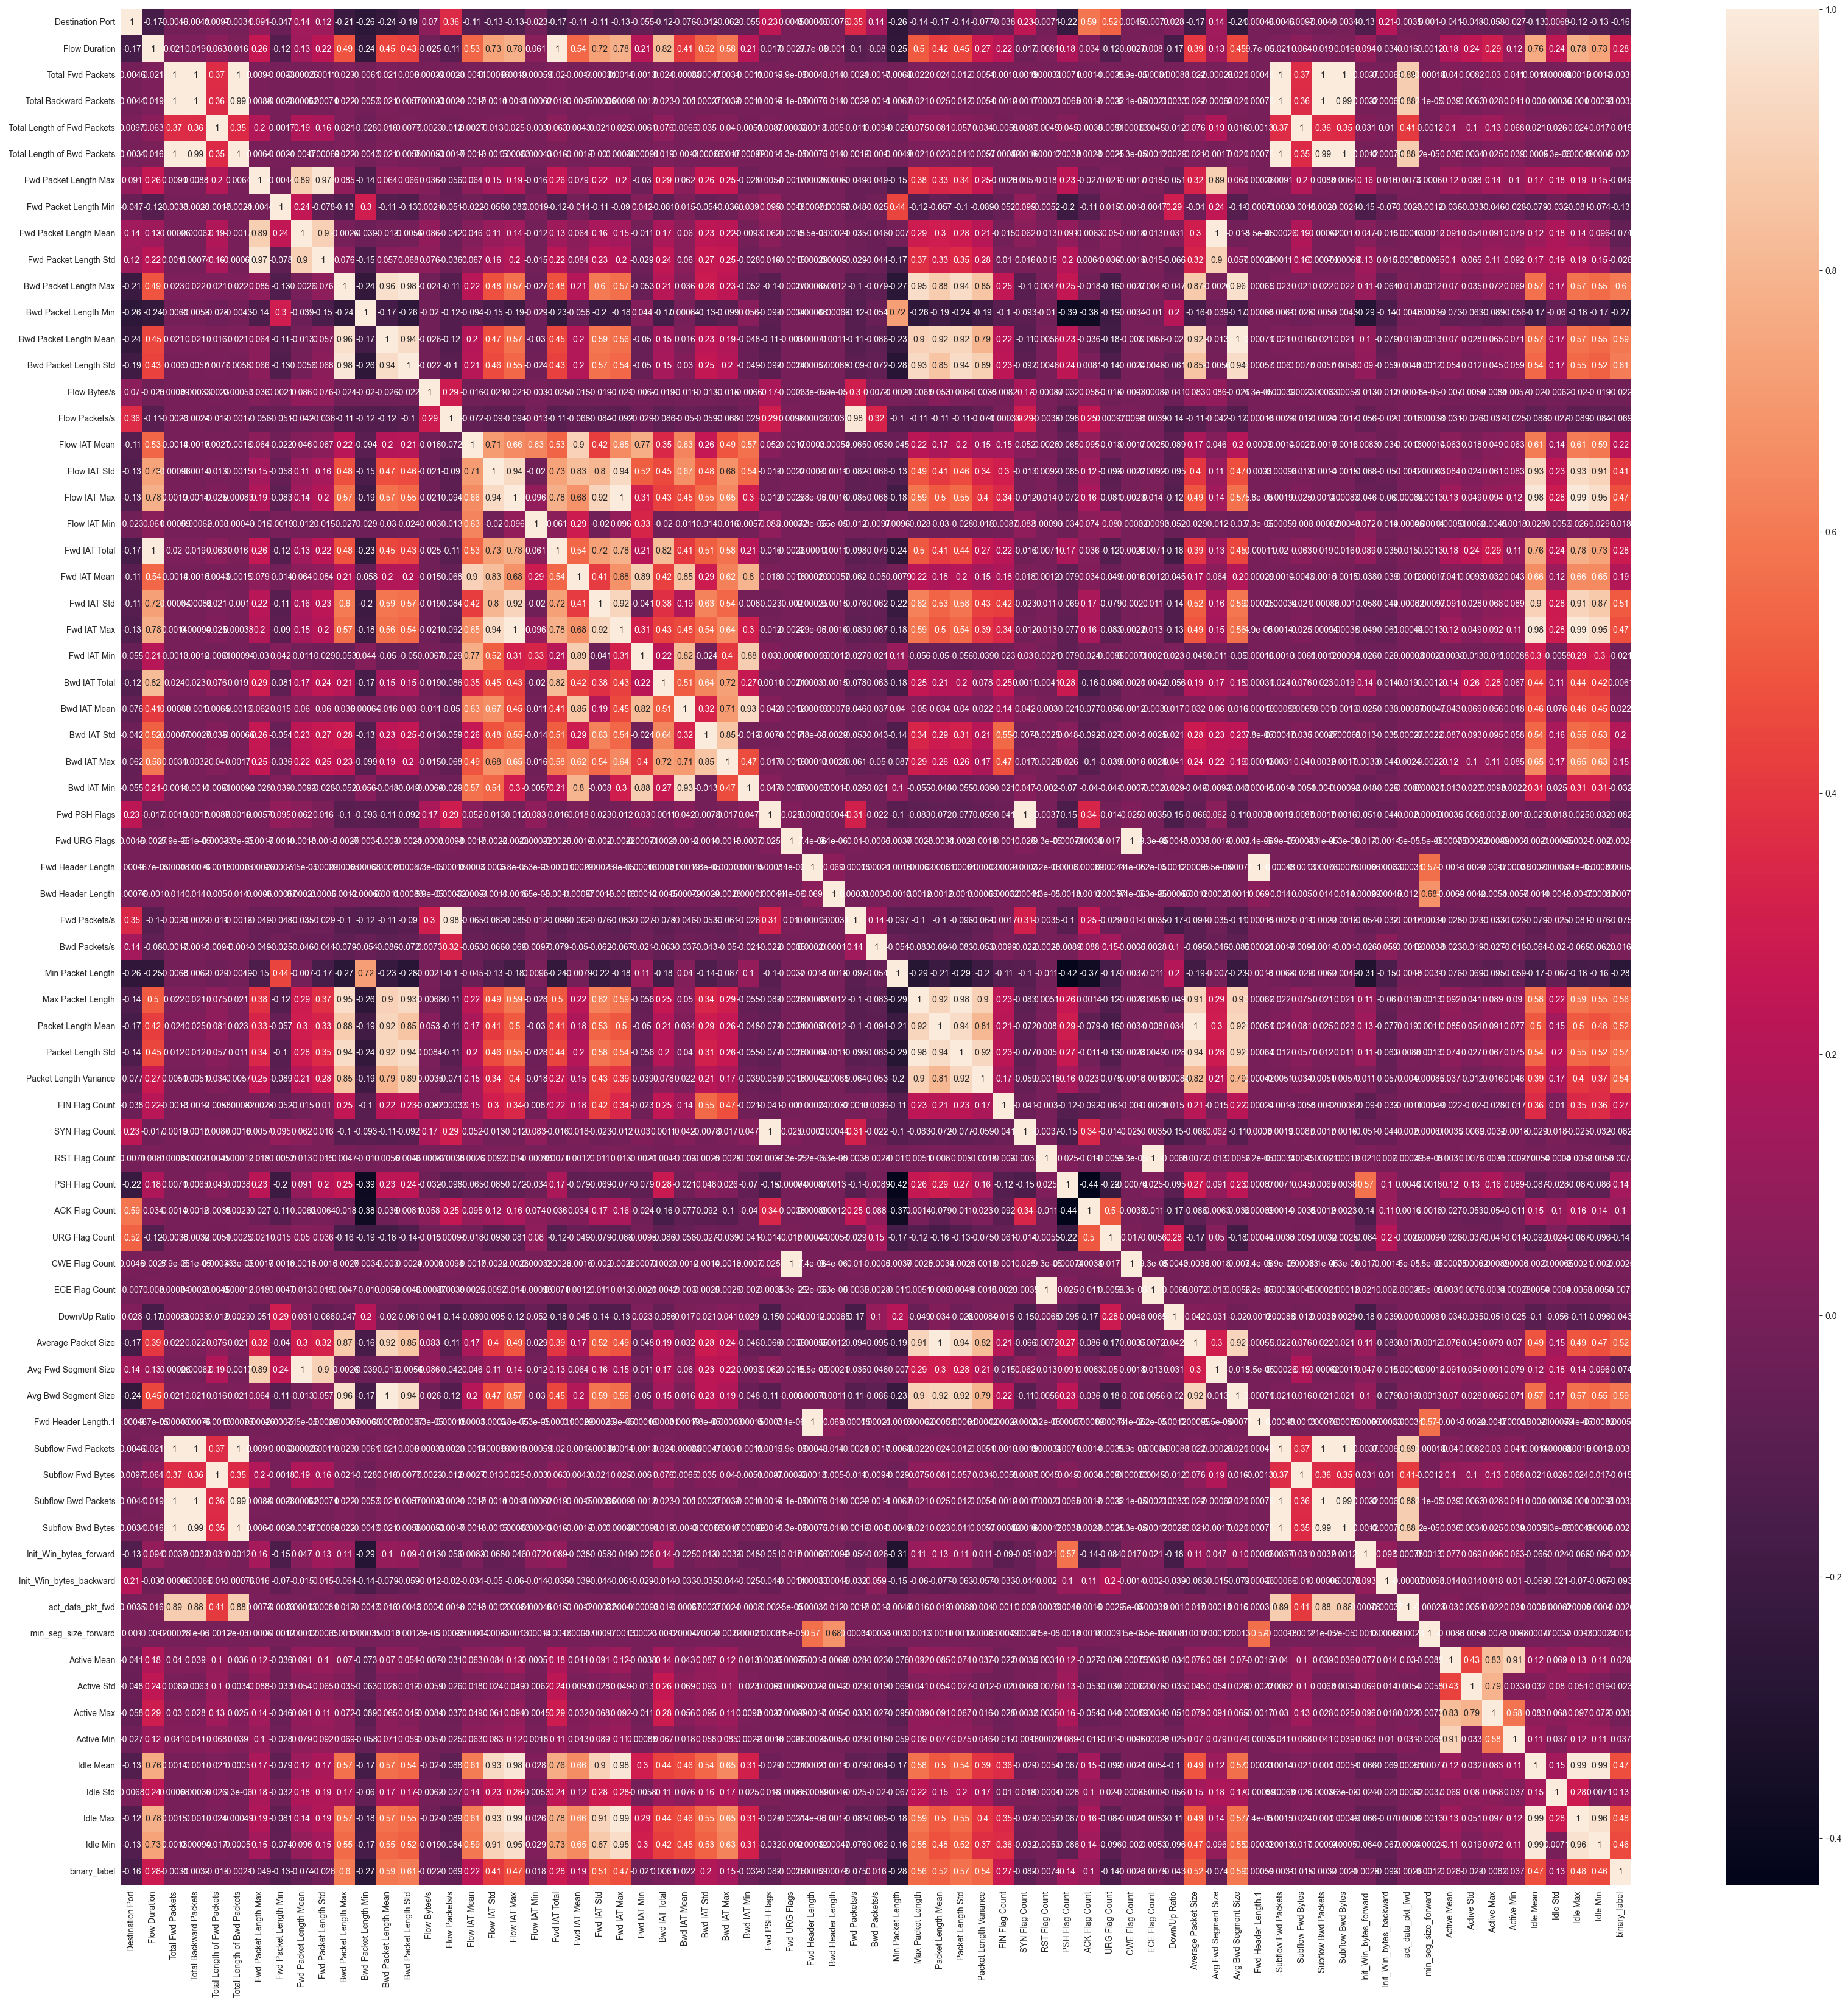

In [7]:
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(40, 40))
sns.heatmap(df_cleaned[numeric_cols].corr(), fmt='.2g', annot=True)

In [11]:
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

[' Destination Port',
 ' Flow Duration',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 ' Fwd Packet Length Std',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Min',
 ' Bwd Packet Length Mean',
 ' Bwd Packet Length Std',
 'Flow Bytes/s',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Max',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 'Bwd IAT Total',
 ' Bwd IAT Mean',
 ' Bwd IAT Std',
 ' Bwd IAT Max',
 ' Bwd IAT Min',
 'Fwd PSH Flags',
 ' Fwd URG Flags',
 ' Fwd Header Length',
 ' Bwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Max Packet Length',
 ' Packet Length Mean',
 ' Packet Length Std',
 ' Packet Length Variance',
 'FIN Flag Count',
 ' SYN Flag Count',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 '

In [12]:
def correlation(a, b):
    return np.corrcoef(a, b)[0, 1]

scores = {}
y_crr = df_cleaned['binary_label']
X_corr = df_cleaned.drop(columns=['binary_label', ' Label'])
for col in X_corr.columns:
    try:
        r_cf = abs(correlation(X_corr[col], y_crr))   # korelacja z klasą
        scores[col] = r_cf
    except:
        scores[col] = 0

ranking = sorted(scores.items(), key=lambda x: x[1], reverse=True)

print("TOP 20 najważniejszych cech:")
for i, (f, s) in enumerate(ranking, 1):
    print(f"{i:2d}. {f:30s}  CFS-score = {s:.4f}")

TOP 20 najważniejszych cech:
 1.  Bwd Packet Length Std          CFS-score = 0.6117
 2. Bwd Packet Length Max           CFS-score = 0.5965
 3.  Bwd Packet Length Mean         CFS-score = 0.5944
 4.  Avg Bwd Segment Size           CFS-score = 0.5944
 5.  Packet Length Std              CFS-score = 0.5735
 6.  Max Packet Length              CFS-score = 0.5555
 7.  Packet Length Variance         CFS-score = 0.5368
 8.  Average Packet Size            CFS-score = 0.5216
 9.  Packet Length Mean             CFS-score = 0.5209
10.  Fwd IAT Std                    CFS-score = 0.5061
11.  Idle Max                       CFS-score = 0.4756
12.  Flow IAT Max                   CFS-score = 0.4715
13. Idle Mean                       CFS-score = 0.4709
14.  Fwd IAT Max                    CFS-score = 0.4708
15.  Idle Min                       CFS-score = 0.4584
16.  Flow IAT Std                   CFS-score = 0.4110
17. Fwd IAT Total                   CFS-score = 0.2801
18.  Flow Duration                  

In [17]:
#zostaw kolumny z korelecja powyzej 0.4
X_corr = X_corr[ [f for f, s in ranking if s > 0.4] ]
X_corr

Bwd Packet Length Std  Bwd Packet Length Max  \
0                           0.0                      0   
1                           0.0                      6   
2                           0.0                      6   
3                           0.0                      6   
4                           0.0                      0   
...                         ...                    ...   
2520793                     0.0                     76   
2520794                     0.0                    181   
2520795                     0.0                      6   
2520796                     0.0                    128   
2520797                     0.0                    113   

          Bwd Packet Length Mean   Avg Bwd Segment Size   Packet Length Std  \
0                            0.0                    0.0            0.000000   
1                            6.0                    6.0            0.000000   
2                            6.0                    6.0            0.000000   
3                            6.0                    6.0            0.000000   
4                            0.0                    0.0            0.000000   
...                          ...                    ...                 ...   
2520793                     76.0                   76.0           23.421602   
2520794                    181.0                  181.0           76.133440   
2520795                      6.0                    6.0           16.350330   
2520796                    128.0                  128.0           42.332020   
2520797                    113.0                  113.0           32.204704   

          Max Packet Length   Packet Length Variance   Average Packet Size  \
0                         6                  0.00000              9.000000   
1                         6                  0.00000              9.000000   
2                         6                  0.00000              9.000000   
3                         6                  0.00000              9.000000   
4                         6                  0.00000              9.000000   
...                     ...                      ...                   ...   
2520793                  76                548.57140             48.666668   
2520794                 181               5796.30000            122.000000   
2520795                  31                267.33334             22.666666   
2520796                 128               1792.00000             60.000000   
2520797                 113               1037.14280             76.833336   

          Packet Length Mean   Fwd IAT Std   Idle Max   Flow IAT Max  \
0                   6.000000         0.000          0              3   
1                   6.000000         0.000          0            109   
2                   6.000000         0.000          0             52   
3                   6.000000         0.000          0             34   
4                   6.000000         0.000          0              3   
...                      ...           ...        ...            ...   
2520793            41.714287     17755.844          0          30780   
2520794            97.600000         0.000          0            320   
2520795            17.000000         0.000          0             78   
2520796            53.333332    444210.060          0        1000947   
2520797            65.857140     42174.280          0          73049   

         Idle Mean   Fwd IAT Max   Idle Min   Flow IAT Std  
0              0.0             3          0        0.00000  
1              0.0             0          0        0.00000  
2              0.0             0          0        0.00000  
3              0.0             0          0        0.00000  
4              0.0             3          0        0.00000  
...            ...           ...        ...            ...  
2520793        0.0         30780          0    13617.57900  
2520794        0.0             2          0      183.59738  
2520795      

PCA

In [32]:
Y_df_clean = df_cleaned['binary_label']
X_df_clean = df_cleaned.drop(columns=['binary_label', ' Label'])

In [33]:
pca = PCA(n_components=30)
principal_components = pca.fit_transform(X_df_clean)

In [34]:
df_pca = pca.transform(X_df_clean)
df_pca = pd.DataFrame(data=df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
df_pca['binary_label'] = Y_df_clean.values
display(df_pca)

PC1           PC2           PC3           PC4           PC5  \
0       -3.459328e+07 -2.996206e+06  37160.960598  2.229918e+06  1.078970e+06   
1       -3.455576e+07 -2.944846e+06  36735.152543 -1.662230e+06  1.097159e+06   
2       -3.455697e+07 -2.946438e+06  36747.493747 -1.541506e+06  1.096606e+06   
3       -3.455816e+07 -2.948050e+06  36759.975785 -1.419286e+06  1.096037e+06   
4       -3.459328e+07 -2.996206e+06  37160.960597  2.229918e+06  1.078970e+06   
...               ...           ...           ...           ...           ...   
2520793 -3.450361e+07 -2.944908e+06  36789.829680 -1.763849e+06  1.080501e+06   
2520794 -3.456761e+07 -2.961576e+06  36892.420927 -3.959893e+05  1.091058e+06   
2520795 -3.455904e+07 -2.949343e+06  36832.399261 -1.321081e+06  1.095558e+06   
2520796 -3.290957e+07 -2.952395e+06  36265.176873 -1.761147e+06  5.015506e+05   
2520797 -3.442510e+07 -2.941101e+06  36804.083260 -1.767125e+06  1.051705e+06   

                   PC6            PC7            PC8            PC9  \
0       -671776.327080  354497.587535 -192444.742587   72620.287003   
1       -678776.322335  357208.626668 -193606.881004   73329.831064   
2       -678579.178168  357146.257601 -193619.847631   73304.637684   
3       -678363.164937  357066.575559 -193594.916469   73279.530315   
4       -671776.326908  354497.587715 -192444.742735   72620.286850   
...                ...            ...            ...            ...   
2520793 -665276.431790  334839.774535 -183810.141069   65126.167562   
2520794 -676441.252113  356076.764187 -193184.090911   73435.037075   
2520795 -678164.065836  356963.598118 -193559.646876   73238.675803   
2520796 -259825.881481 -345934.104254   80075.361944 -155630.791938   
2520797 -642408.823297  303067.071334 -168868.497048   53573.081577   

                  PC10           PC11           PC12           PC13  \
0       -209911.102024  128492.011266   46131.172217  109688.682763   
1       -210373.982784  128806.534893   45915.960909  108862.157795   
2       -210350.634849  128807.283795   45876.783596  108886.168232   
3       -210326.964690  128794.796829   45869.096669  108901.840801   
4       -209911.101583  128492.011452   46131.172260  109688.682643   
...                ...            ...            ...            ...   
2520793 -188372.466579  116545.702861   36830.045262  110006.065666   
2520794 -209562.269803  128651.957677   45466.733511  108472.744760   
2520795 -210244.020461  128756.769589   45802.235107  108810.378433   
2520796  397501.230768 -378581.610335 -224477.161937  101334.837152   
2520797 -158004.312923   99133.613361   27309.501860  105099.417001   

                  PC14          PC15           PC16          PC17  \
0        333209.348776  21444.819300 -271895.023795  71228.475532   
1        329169.511920  21219.563499 -264311.080170  69834.027265   
2        329316.214904  21228.359562 -264499.479483  69875.000975   
3        329418.774728  21234.335620 -264691.062027  69908.365735   
4        333209.348903  21444.819280 -271895.023260  71228.475344   
...                ...           ...            ...           ...   
2520793  325097.257111  20945.951681 -264752.825398  66548.585020   
2520794  327261.509783  21142.815038 -258965.392754  69911.062670   
2520795  329137.874172  21223.182345 -264318.455362  69848.983975   
2520796  220463.392056  13569.652774 -295868.246466  51154.117556   
2520797  312294.663274  20130.106706 -266666.473712  58975.115073   

                 PC18          PC19          PC20        PC21          PC22  \
0       -15306.282819 -40669.971609 -19397.971810  512.199397  39166.665072   
1       -14762.264492 -36665.554103 -16287.271218  526.282553  29723.986604   
2       -14764.654802 -36775.920978 -16360.144488  526.025006  29951.556160   
3       -14774.188745 -36873.123409 -16433.573637  525.701492  30176.510525   
4       -15306.283246 -40669.970416 -19397.972650  512.199358  39166.664787   
...               ...           ... 

Zapisz dane po PCA

In [35]:
df_pca.to_csv('./MachineLearningCVE/pca_transformed_dataset_30.csv', index=False)

<Axes: >

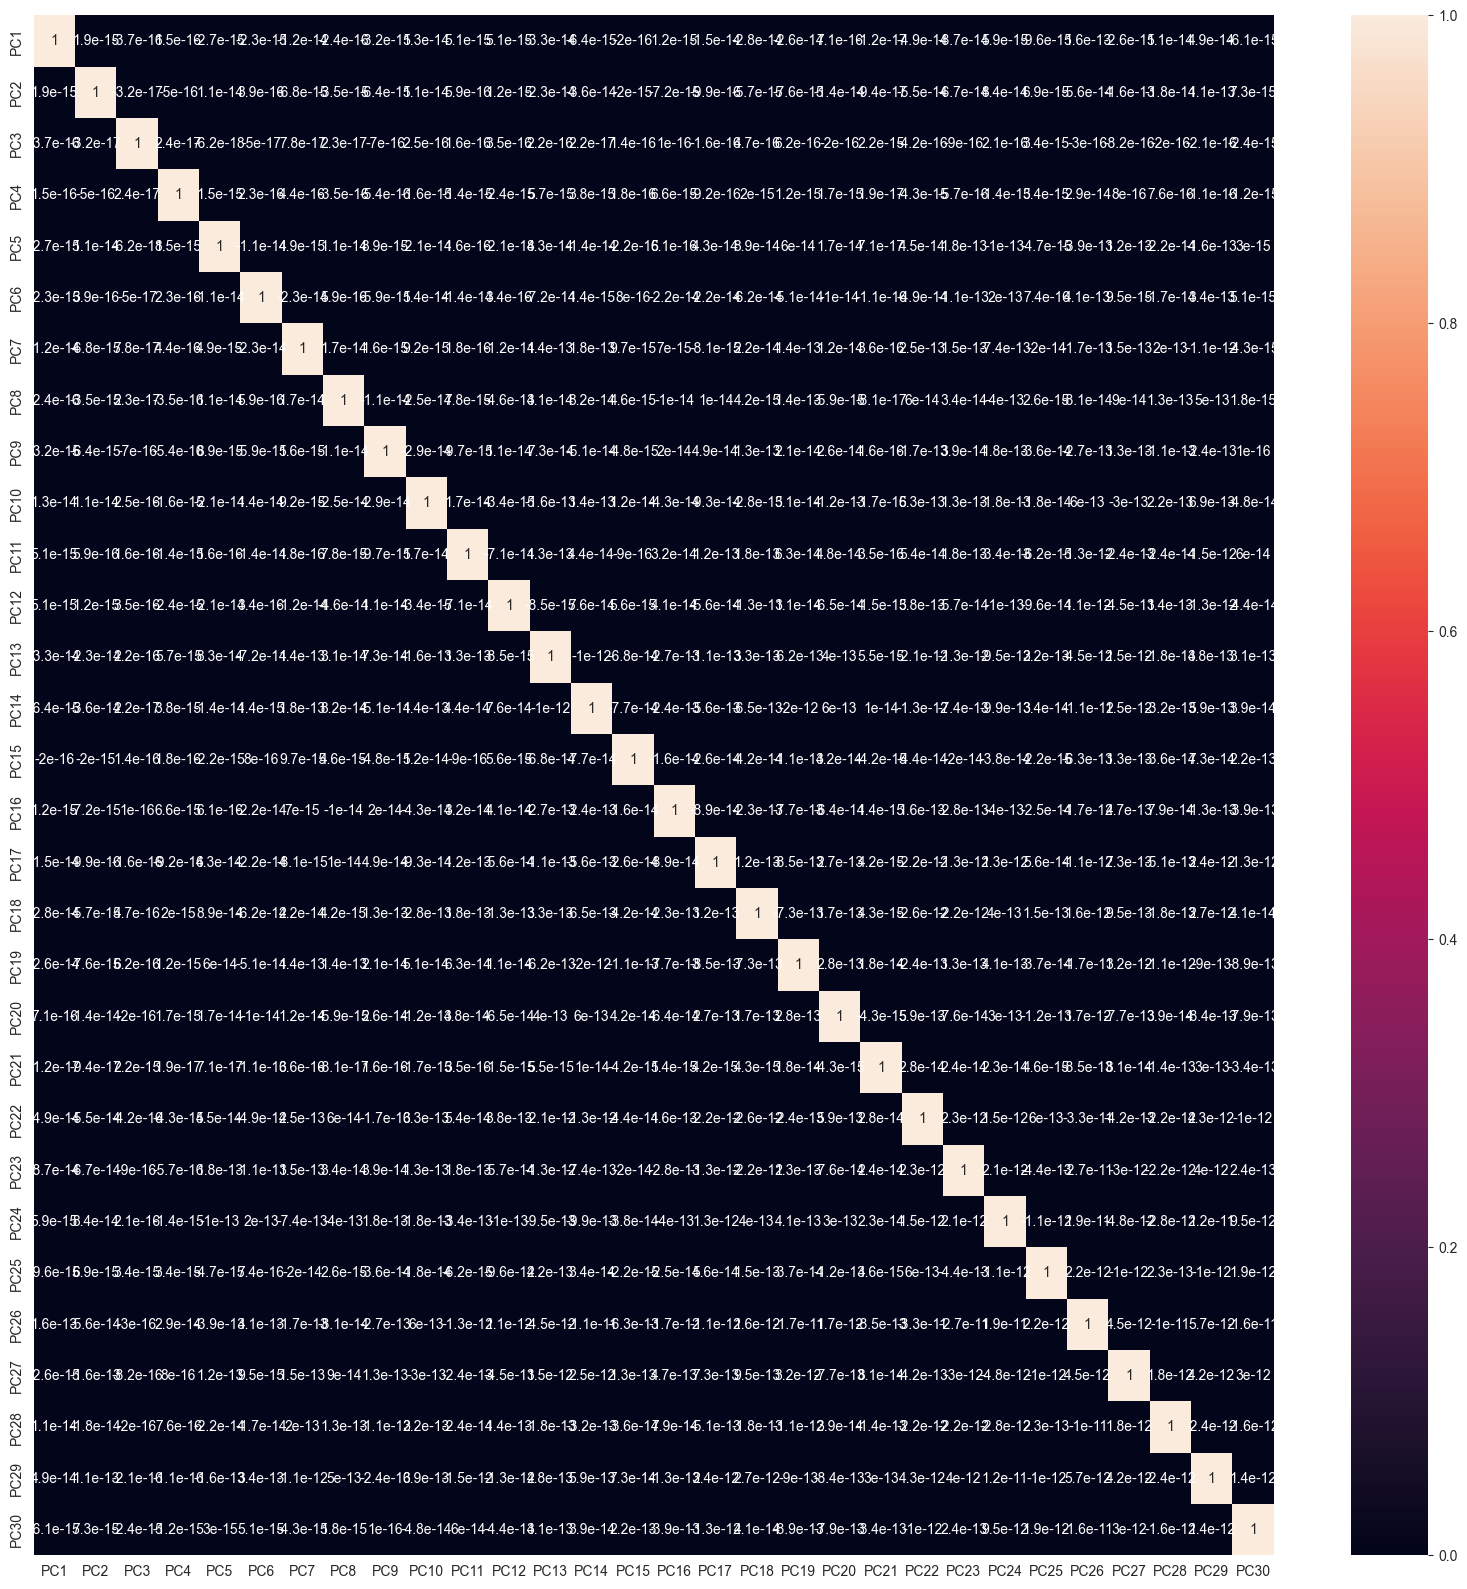

In [36]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_pca.drop(columns=['binary_label']).corr(), fmt='.2g', annot=True)

#### PCA dla 2 wymiarów

C:\Users\zuzka\AppData\Local\Temp\ipykernel_27468\695257191.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(classes))
s:\PWR\PNW\PNW2\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


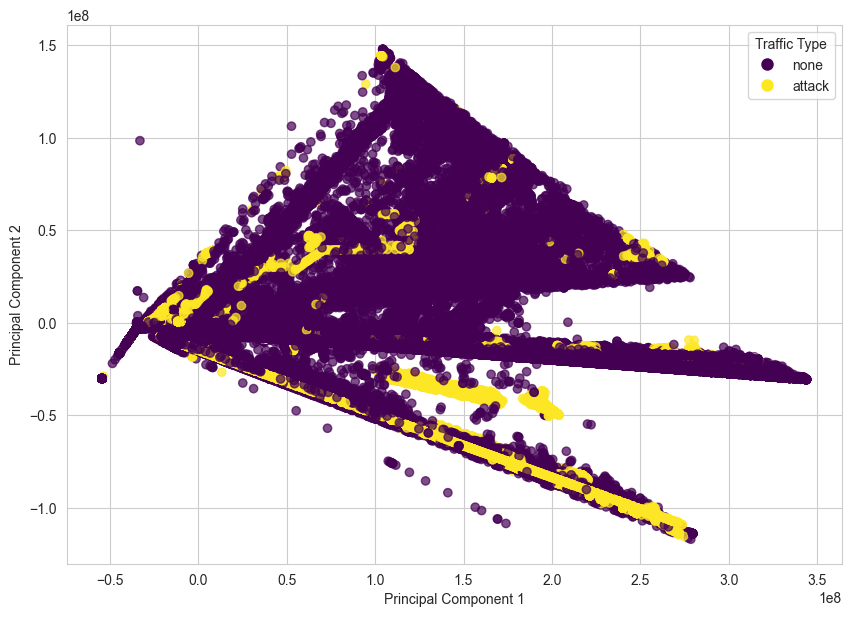

In [ ]:
pca2 = PCA(n_components=2)
principal_components = pca2.fit_transform(X_df_clean)

plt.figure(figsize=(10, 7))

scatter = plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=Y_df_clean,
    cmap='viridis',
    alpha=0.7
)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


labels = {
    0: 'none',
    1: 'attack'
}

classes = np.unique(Y_df_clean)

cmap = plt.cm.get_cmap('viridis', len(classes))
handles = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=cmap(i), markersize=10,
               label=labels[cls])
    for i, cls in enumerate(classes)
]

plt.legend(handles=handles, title="Traffic Type")

plt.show()

## Definicja modelu Autoencoder

Definiujemy prosty model autoenkodera przy użyciu Keras. Składać się będzie z warstwy kodującej i dekodującej.

In [ ]:
def create_autoencoder(input_dim, encoding_dim_ratio=0.5, intermediate_dim_ratio=0.75):
    """
    Tworzy model autoenkodera.
    input_dim: liczba cech wejściowych.
    encoding_dim_ratio: stosunek wymiaru warstwy kodującej do wymiaru wejściowego.
    intermediate_dim_ratio: stosunek wymiaru warstwy pośredniej do wymiaru wejściowego.
    """
    encoding_dim = max(2, int(input_dim * encoding_dim_ratio))
    intermediate_dim = max(encoding_dim +1 , int(input_dim * intermediate_dim_ratio))

    # Input -> Dense (intermediate) -> Dense (encoding) -> Dense (intermediate) -> Output
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(intermediate_dim, activation='relu', name='encoder_intermediate'),
        Dense(encoding_dim, activation='relu', name='encoder_bottleneck'),
        Dense(intermediate_dim, activation='relu', name='decoder_intermediate'),
        Dense(input_dim, activation='sigmoid', name='decoder_output')
    ], name="Autoencoder")
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(f"Autoencoder: Input({input_dim}) -> {intermediate_dim} -> {encoding_dim} -> {intermediate_dim} -> {input_dim}")
    return model

_test_ae = create_autoencoder(X.shape[1])
_test_ae.summary()
del _test_ae
print("Definicja Autoenkodera gotowa.")

In [ ]:
def create_autoencoder2(input_dim, encoding_dim_ratio=0.5, intermediate_dim_ratio=0.75):
    """
    Tworzy model autoenkodera z dodatkowymi warstwami BatchNormalization i Dropout.
    input_dim: liczba cech wejściowych.
    encoding_dim_ratio: stosunek wymiaru warstwy kodującej do wymiaru wejściowego.
    intermediate_dim_ratio: stosunek wymiaru warstwy pośredniej do wymiaru wejściowego.
    """
    encoding_dim = int(input_dim * encoding_dim_ratio)
    intermediate_dim = max(encoding_dim + 1, int(input_dim * intermediate_dim_ratio))
    intermediate_dim = min(intermediate_dim, input_dim - 1)

    # Encoder
    encoder_input = Input(shape=(input_dim,))
    x = Dense(intermediate_dim, activation='relu', name='encoder_intermediate_1')(encoder_input)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(encoding_dim, activation='relu', name='encoder_bottleneck')(x)
    encoder_output = BatchNormalization()(x)

    # Decoder
    x = Dense(intermediate_dim, activation='relu', name='decoder_intermediate_1')(encoder_output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    decoder_output = Dense(input_dim, activation='linear', name='decoder_output')(x)

    model = Model(inputs=encoder_input, outputs=decoder_output, name="Autoencoder")

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    print(f"Autoencoder: Input({input_dim}) -> {intermediate_dim} -> {encoding_dim} -> {intermediate_dim} -> {input_dim}")
    return model

_test_ae = create_autoencoder2(X.shape[1])
_test_ae.summary()
del _test_ae
print("Definicja Autoenkodera2 gotowa.")

## 1.2 Wybór hyperparametrów 

In [6]:
df_pca = pd.read_csv('./MachineLearningCVE/pca_transformed_dataset.csv', low_memory=False)
display(df_pca)

PC1           PC2           PC3           PC4           PC5  \
0       -3.459328e+07 -2.996206e+06  37160.960589  2.229918e+06  1.078970e+06   
1       -3.455576e+07 -2.944846e+06  36735.152543 -1.662230e+06  1.097159e+06   
2       -3.455697e+07 -2.946438e+06  36747.493746 -1.541506e+06  1.096606e+06   
3       -3.455816e+07 -2.948050e+06  36759.975786 -1.419286e+06  1.096037e+06   
4       -3.459328e+07 -2.996206e+06  37160.960588  2.229918e+06  1.078970e+06   
...               ...           ...           ...           ...           ...   
2520793 -3.450361e+07 -2.944908e+06  36789.829681 -1.763849e+06  1.080501e+06   
2520794 -3.456761e+07 -2.961576e+06  36892.420919 -3.959894e+05  1.091058e+06   
2520795 -3.455904e+07 -2.949343e+06  36832.399260 -1.321081e+06  1.095558e+06   
2520796 -3.290957e+07 -2.952395e+06  36265.176874 -1.761147e+06  5.015506e+05   
2520797 -3.442510e+07 -2.941101e+06  36804.083261 -1.767125e+06  1.051705e+06   

                   PC6            PC7            PC8            PC9  \
0       -671776.327082  354497.587541 -192444.742586   72620.287259   
1       -678776.322405  357208.626690 -193606.881007   73329.831320   
2       -678579.178241  357146.257625 -193619.847635   73304.637941   
3       -678363.164976  357066.575568 -193594.916465   73279.530567   
4       -671776.326910  354497.587721 -192444.742735   72620.287106   
...                ...            ...            ...            ...   
2520793 -665276.431920  334839.774533 -183810.141062   65126.167752   
2520794 -676441.252253  356076.764237 -193184.090931   73435.037341   
2520795 -678164.065897  356963.598137 -193559.646877   73238.676058   
2520796 -259825.878993 -345934.104277   80075.363906 -155630.792178   
2520797 -642408.823185  303067.071535 -168868.497404   53573.081981   

                  PC10           PC11           PC12           PC13  \
0       -209911.101883  128492.011355   46131.172250  109688.682701   
1       -210373.982627  128806.534971   45915.960929  108862.157698   
2       -210350.634694  128807.283874   45876.783616  108886.168137   
3       -210326.964526  128794.796901   45869.096688  108901.840699   
4       -209911.101441  128492.011540   46131.172293  109688.682581   
...                ...            ...            ...            ...   
2520793 -188372.466339  116545.702967   36830.045339  110006.065672   
2520794 -209562.269660  128651.957775   45466.733526  108472.744676   
2520795 -210244.020302  128756.769664   45802.235127  108810.378334   
2520796  397501.229814 -378581.609065 -224477.162926  101334.836717   
2520797 -158004.313310   99133.613116   27309.501360  105099.416363   

                  PC14          PC15           PC16          PC17  \
0        333209.348987  21444.819284 -271895.024007  71228.475545   
1        329169.511990  21219.563475 -264311.080173  69834.027234   
2        329316.214981  21228.359538 -264499.479493  69875.000946   
3        329418.774785  21234.335595 -264691.062033  69908.365698   
4        333209.349114  21444.819264 -271895.023472  71228.475357   
...                ...           ...            ...           ...   
2520793  325097.257201  20945.951657 -264752.825400  66548.584904   
2520794  327261.509842  21142.815014 -258965.392565  69911.062659   
2520795  329137.874238  21223.182321 -264318.455370  69848.983942   
2520796  220463.392972  13569.652821 -295868.246391  51154.117221   
2520797  312294.663352  20130.106692 -266666.473761  58975.115567   

                 PC18          PC19  binary_label  
0       -15306.282847 -40669.971672             0  
1       -14762.264502 -36665.554062             0  
2       -14764.654814 -36775.920942             0  
3       -14774.188755 -36873.123364             0  
4       -15306.283273 -40669.970479             0  
...               ...           ...           ...  
2520793 -15335.265800 -35460.644266             0  
2520794 -14748.868293 -36351.341584             0  
2520795 -14761.518644 -36747.835595       

In [37]:
old_memory_usage = df_pca.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in df_pca.columns:
    col_type = df_pca[col].dtype
    if col_type != object:
        c_min = df_pca[col].min()
        c_max = df_pca[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df_pca[col] = df_pca[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            df_pca[col] = df_pca[col].astype(np.int32)
new_memory_usage = df_pca.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")
print(f'Reduced memory usage: {1 - (new_memory_usage / old_memory_usage):.2%}')

Initial memory usage: 586.58 MB
Final memory usage: 298.10 MB
Reduced memory usage: 49.18%


In [38]:
display(df_pca)
old_memory_usage = df_pca.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')

PC1         PC2           PC3           PC4           PC5  \
0       -34593284.0 -2996206.25  37160.960938  2.229918e+06  1.078970e+06   
1       -34555764.0 -2944845.75  36735.152344 -1.662230e+06  1.097159e+06   
2       -34556968.0 -2946438.00  36747.492188 -1.541506e+06  1.096606e+06   
3       -34558156.0 -2948049.75  36759.976562 -1.419286e+06  1.096037e+06   
4       -34593284.0 -2996206.25  37160.960938  2.229918e+06  1.078970e+06   
...             ...         ...           ...           ...           ...   
2520793 -34503612.0 -2944908.50  36789.828125 -1.763849e+06  1.080501e+06   
2520794 -34567612.0 -2961575.50  36892.421875 -3.959893e+05  1.091058e+06   
2520795 -34559040.0 -2949343.50  36832.398438 -1.321081e+06  1.095558e+06   
2520796 -32909570.0 -2952395.50  36265.175781 -1.761146e+06  5.015506e+05   
2520797 -34425100.0 -2941100.75  36804.082031 -1.767124e+06  1.051705e+06   

                 PC6           PC7            PC8            PC9  \
0       -671776.3125  354497.59375 -192444.750000   72620.289062   
1       -678776.3125  357208.62500 -193606.875000   73329.828125   
2       -678579.1875  357146.25000 -193619.843750   73304.640625   
3       -678363.1875  357066.56250 -193594.921875   73279.531250   
4       -671776.3125  354497.59375 -192444.750000   72620.289062   
...              ...           ...            ...            ...   
2520793 -665276.4375  334839.78125 -183810.140625   65126.167969   
2520794 -676441.2500  356076.75000 -193184.093750   73435.039062   
2520795 -678164.0625  356963.59375 -193559.640625   73238.679688   
2520796 -259825.8750 -345934.09375   80075.359375 -155630.796875   
2520797 -642408.8125  303067.06250 -168868.500000   53573.082031   

                  PC10           PC11           PC12           PC13  \
0       -209911.109375  128492.007812   46131.171875  109688.679688   
1       -210373.984375  128806.531250   45915.960938  108862.156250   
2       -210350.640625  128807.281250   45876.785156  108886.171875   
3       -210326.968750  128794.796875   45869.097656  108901.843750   
4       -209911.109375  128492.007812   46131.171875  109688.679688   
...                ...            ...            ...            ...   
2520793 -188372.468750  116545.703125   36830.046875  110006.062500   
2520794 -209562.265625  128651.960938   45466.734375  108472.742188   
2520795 -210244.015625  128756.773438   45802.234375  108810.375000   
2520796  397501.218750 -378581.625000 -224477.156250  101334.835938   
2520797 -158004.312500   99133.617188   27309.501953  105099.414062   

                  PC14          PC15           PC16          PC17  \
0        333209.343750  21444.818359 -271895.031250  71228.476562   
1        329169.500000  21219.564453 -264311.093750  69834.023438   
2        329316.218750  21228.359375 -264499.468750  69875.000000   
3        329418.781250  21234.335938 -264691.062500  69908.367188   
4        333209.343750  21444.818359 -271895.031250  71228.476562   
...                ...           ...            ...           ...   
2520793  325097.250000  20945.951172 -264752.812500  66548.585938   
2520794  327261.500000  21142.814453 -258965.390625  69911.062500   
2520795  329137.875000  21223.181641 -264318.468750  69848.984375   
2520796  220463.390625  13569.652344 -295868.250000  51154.117188   
2520797  312294.656250  20130.107422 -266666.468750  58975.113281   

                 PC18          PC19          PC20        PC21          PC22  \
0       -15306.283203 -40669.972656 -19397.972656  512.199402  39166.664062   
1       -14762.264648 -36665.554688 -16287.271484  526.282532  29723.986328   
2       -14764.655273 -36775.921875 -16360.144531  526.025024  29951.556641   
3       -14774.188477 -36873.125000 -16433.574219  525.701477  30176.509766   
4       -15306.283203 -40669.968750 -19397.972656  512.199341  39166.664062   
...               ...           ...           ...         ...           ...   
2520793 -15335.265625 -35460.644531 -16

Initial memory usage: 298.10 MB


In [12]:
#normalize data of df_pca
df_cleaned = df_cleaned.drop(columns=[' Label'])
scaler = QuantileTransformer(output_distribution='normal')
scaled_features = scaler.fit_transform(df_cleaned.drop(columns=['binary_label']))
df_cleaned_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.columns[:-1])
df_cleaned_scaled['binary_label'] = df_cleaned['binary_label'].values
display(df_cleaned_scaled)
scaled_memory_usage = df_cleaned_scaled.memory_usage().sum() / 1024 ** 2
print(f'Scaled memory usage: {scaled_memory_usage:.2f} MB')

Destination Port   Flow Duration   Total Fwd Packets  \
0                 1.594914       -2.119668           -0.232930   
1                 1.609470       -0.948812           -5.199338   
2                 1.609524       -1.269664           -5.199338   
3                 1.181964       -1.497997           -5.199338   
4                 1.594749       -2.119668           -0.232930   
...                    ...             ...                 ...   
2520793          -0.892038       -0.135511            0.482248   
2520794          -0.892038       -0.532534           -0.232930   
2520795           1.880264       -1.033647           -0.232930   
2520796          -0.892038        0.485837            0.715218   
2520797          -0.892038        0.182372            0.482248   

          Total Backward Packets  Total Length of Fwd Packets  \
0                      -5.199338                    -0.751333   
1                      -0.647177                    -0.905189   
2                      -0.647177                    -0.905189   
3                      -0.647177                    -0.905189   
4                      -5.199338                    -0.751333   
...                          ...                          ...   
2520793                 0.089192                     0.426601   
2520794                 0.089192                     0.243255   
2520795                -0.647177                    -0.516356   
2520796                 0.089192                     0.573115   
2520797                 0.089192                     0.570161   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
0                           -5.199338               -0.779924   
1                           -0.650274               -0.779924   
2                           -0.650274               -0.779924   
3                           -0.650274               -0.779924   
4                           -5.199338               -0.779924   
...                               ...                     ...   
2520793                     -0.033880               -0.480839   
2520794                      0.483658                0.053973   
2520795                     -0.650274               -0.384375   
2520796                      0.324254               -0.320290   
2520797                      0.252311                0.258792   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
0                      0.176553                -0.752997   
1                      0.176553                -0.752997   
2                      0.176553                -0.752997   
3                      0.176553                -0.752997   
4                      0.176553                -0.752997   
...                         ...                      ...   
2520793                0.352151                -0.316330   
2520794                0.905189                 0.205941   
2520795               -5.199338                -0.440383   
2520796                0.458426                -0.208505   
2520797                1.218002                 0.440383   

          Fwd Packet Length Std  Bwd Packet Length Max  \
0                     -5.199338              -5.199338   
1                     -5.199338              -0.613509   
2                     -5.199338              -0.613509   
3                     -5.199338              -0.613509   
4                     -5.199338              -5.199338   
...                         ...                    ...   
2520793               -5.199338              -0.172731   
2520794               -5.199338               0.454143   
2520795                0.536531              -0.613509   
2520796               -5.199338               0.220058   
2520797               -5.199338               0.119468   

          Bwd Packet Length Min   Bwd Packet Length Mean  \
0                     -5.199338                -5.199338   
1                      0.179102                -0.601439   
2                      0.179102                -0.601439 

Scaled memory usage: 1355.87 MB


In [55]:
# y = df_cleaned_scaled['binary_label']
# X = df_cleaned_scaled.drop(columns=['binary_label'])
y = y_crr
X = X_corr

In [22]:
global_contamination_rate = y.value_counts(normalize=True).get(1)
print(f"Globalny wpółczynnik anomalii w zbiorze do strojenia: {global_contamination_rate:.2%}")

Globalny wpółczynnik anomalii w zbiorze do strojenia: 16.89%


In [15]:
test_size_for_tuning = 0.20

X, X_tuning_set, y, y_tuning_set = train_test_split(
    X, y, test_size=test_size_for_tuning, random_state=RANDOM_STATE, stratify=y
)

print(f"Zbiór CV: {X.shape}, Zbiór do strojenia: {X_tuning_set.shape}")

Zbiór CV: (2016638, 70), Zbiór do strojenia: (504160, 70)


### Isolation forest
- n_estimators: Liczba drzew bazowych w ensemblu.

- max_samples: Liczba próbek losowanych do trenowania każdego drzewa.

- contamination: Oczekiwany odsetek anomalii w zbiorze danych.

- max_features: Liczba cech losowanych do rozważenia przy szukaniu najlepszego podziału w węźle drzewa.


IF, OCSVM: im niższy score, tym bardziej model uważa próbkę za anomalię.

roc_auc_score zakłada, że wyższy score = większe prawdopodobieństwo klasy pozytywnej (tu: ataku).

Dlatego odwraca się znaki: -y_pred_scores, żeby "najbardziej anomalia" miała najwyższy score dla AUC

In [ ]:
model_name = "IsolationForest"
n_iter = 15

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [256, 512, 'auto'],
    'contamination': [global_contamination_rate],
    'max_features': [0.5, 0.7, 1.0]
}

scalers = {
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

all_param_combinations = list(product(*param_grid.values()))
random.shuffle(all_param_combinations)
random_combinations = all_param_combinations[:n_iter]

best_auc_total = 0
best_params_total = None
best_scaler_total = None

scaler_win_counts = {name: 0 for name in scalers}

K = 3
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_tuning_set, y_tuning_set)):
    print(f"\n====================== {model_name} === FOLD {fold_idx}/{K} ==============================")

    X_train_raw, y_train_raw = X_tuning_set.iloc[train_idx], y_tuning_set.iloc[train_idx]
    X_test, y_test = X_tuning_set.iloc[test_idx], y_tuning_set.iloc[test_idx]

    X_train = X_train_raw[y_train_raw == 0]  # tylko normalne
    print(f"Rozmiar X_train: {X_train.shape}, Rozmiar X_test: {X_test.shape}, Normalne w teście: {(y_test==0).sum()}, Anomalie: {(y_test==1).sum()}")

    best_auc = 0
    best_params = None
    best_scaler_name = None
    best_scaler_obj = None

    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for i, combo in enumerate(random_combinations):
            params = dict(zip(param_grid.keys(), combo))
            print(f"[{scaler_name}] {i+1}/{n_iter} Sprawdzanie parametrów: {params}")

            model = IsolationForest(random_state=RANDOM_STATE, n_jobs=-1, **params)
            model.fit(X_train_scaled)
            y_pred = model.predict(X_test_scaled)
            scores = -model.decision_function(X_test_scaled)

            auc = roc_auc_score(y_test, scores)

            if auc > best_auc:
                best_auc = auc
                best_params = params
                best_scaler_name = scaler_name
                best_scaler_obj = scaler

            if auc > best_auc_total:
                best_auc_total = auc
                best_params_total = params
                best_scaler_total = scaler_name

    print(f"\nNajlepszy skaler w foldzie: {best_scaler_name}")
    print(f"Najlepsze parametry w foldzie ({best_scaler_name}): {best_params}")
    print(f"Najlepszy wynik AUC w foldzie ({best_scaler_name}): {best_auc:.4f}")
    scaler_win_counts[best_scaler_name] += 1

    # Ostateczne dopasowanie i ocena dla najlepszego skalera i parametrów
    X_train_scaled = best_scaler_obj.fit_transform(X_train)
    X_test_scaled = best_scaler_obj.transform(X_test)

    model = IsolationForest(random_state=RANDOM_STATE, n_jobs=-1, **best_params)
    model.fit(X_train_scaled)
    y_pred = model.predict(X_test_scaled)
    scores = -model.decision_function(X_test_scaled)
    y_pred_bin = [1 if x == -1 else 0 for x in y_pred]

    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_test, scores)

    print(f"    {model_name} - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")


print("\n--- Zakończono walidację krzyżową ---")
print(f"Najlepsze globalne parametry: {best_params_total}")
print(f"Najlepszy globalny wynik AUC: {best_auc_total:.4f}")
print(f"Najlepszy globalnie skaler: {best_scaler_total}")
print(f"\nLiczba zwycięstw skalera (foldów):")
for name, count in scaler_win_counts.items():
    print(f"  {name}: {count}x")

### OC-SVM
- kernel: Typ jądra używanego w algorytmie, może to być'rbf' (Radial Basis Function), 'linear', 'poly', 'sigmoid', ‘precomputed’.

- nu: Parametr z zakresu (0, 1], który stanowi górne ograniczenie na frakcję błędów treningowych (próbek normalnych sklasyfikowanych jako anomalie) oraz dolne ograniczenie na frakcję wektorów wsparcia, domyślnie 0.5

- gamma: Współczynnik jądra dla 'rbf', 'poly' i 'sigmoid'. Definiuje, jak duży wpływ ma pojedyncza próbka treningowa.

In [11]:
model_name = "OneClassSVM"
n_iter = 10

nu_options = [0.01, 0.05, 0.1, 0.15, 0.2]
nu_options.append(global_contamination_rate)
nu_options = sorted(list(set(nu_options)))

param_grid = {
    'kernel': ['rbf'],
    'nu': nu_options,
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]
}

scalers = {
    # 'RobustScaler': RobustScaler(),
    # 'StandardScaler': StandardScaler(),
    # 'MinMaxScaler': MinMaxScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

all_param_combinations = list(product(*param_grid.values()))
random.shuffle(all_param_combinations)
random_combinations = all_param_combinations[:n_iter]

best_auc_total = 0
best_params_total = None
best_scaler_total = None

scaler_win_counts = {name: 0 for name in scalers}

K = 2
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_tuning_set, y_tuning_set)):
    print(f"\n====================== {model_name} === FOLD {fold_idx + 1}/{K} ==============================")

    X_train_raw, y_train_raw = X_tuning_set.iloc[train_idx], y_tuning_set.iloc[train_idx]
    X_test, y_test = X_tuning_set.iloc[test_idx], y_tuning_set.iloc[test_idx]

    X_train = X_train_raw[y_train_raw == 0]
    print(f"Size of X_train: {X_train.shape}, Size of X_test: {X_test.shape}, Normal in test: {(y_test==0).sum()}, Anomalies: {(y_test==1).sum()}")

    best_auc = 0
    best_params = None
    best_scaler_name = None
    best_scaler_obj = None

    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for i, combo in enumerate(random_combinations):
            params = dict(zip(param_grid.keys(), combo))
            print(f"[{scaler_name}] {i+1}/{n_iter} Checking params: {params}")

            model = OneClassSVM(tol=0.01, verbose=False, cache_size=500, **params)
            model.fit(X_train_scaled)

            scores = -model.decision_function(X_test_scaled)
            auc = roc_auc_score(y_test, scores)

            if auc > best_auc:
                best_auc = auc
                best_params = params
                best_scaler_name = scaler_name
                best_scaler_obj = scaler

            if auc > best_auc_total:
                best_auc_total = auc
                best_params_total = params
                best_scaler_total = scaler_name

    print(f"\nBest scaler in fold: {best_scaler_name}")
    print(f"Best params in fold ({best_scaler_name}): {best_params}")
    print(f"Best AUC score in fold ({best_scaler_name}): {best_auc:.4f}")
    scaler_win_counts[best_scaler_name] += 1

    X_train_scaled = best_scaler_obj.fit_transform(X_train)
    X_test_scaled = best_scaler_obj.transform(X_test)

    model = OneClassSVM(tol=0.01, verbose=False, cache_size=500, **best_params)
    model.fit(X_train_scaled)
    y_pred = model.predict(X_test_scaled)
    scores = -model.decision_function(X_test_scaled)

    # Convert predictions (-1 for anomaly, 1 for normal) to binary (1 for anomaly, 0 for normal)
    y_pred_bin = [1 if x == -1 else 0 for x in y_pred]

    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_test, scores)

    print(f"    {model_name} - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")


print("\n--- Cross-validation finished ---")
print(f"Best global parameters: {best_params_total}")
print(f"Best global AUC score: {best_auc_total:.4f}")
print(f"Best global scaler: {best_scaler_total}")
print(f"\nScaler win counts (by fold):")
for name, count in scaler_win_counts.items():
    print(f"  {name}: {count}x")


====================== OneClassSVM === FOLD 1/2 ==============================
Size of X_train: (209506, 19), Size of X_test: (252080, 19), Normal in test: 209506, Anomalies: 42574
[QuantileTransformer] 1/10 Checking params: {'kernel': 'rbf', 'nu': 0.15, 'gamma': 1.0}
[QuantileTransformer] 2/10 Checking params: {'kernel': 'rbf', 'nu': 0.2, 'gamma': 0.001}
[QuantileTransformer] 3/10 Checking params: {'kernel': 'rbf', 'nu': np.float64(0.16889135900615598), 'gamma': 1.0}
[QuantileTransformer] 4/10 Checking params: {'kernel': 'rbf', 'nu': 0.01, 'gamma': 0.01}
[QuantileTransformer] 5/10 Checking params: {'kernel': 'rbf', 'nu': 0.2, 'gamma': 'auto'}
[QuantileTransformer] 6/10 Checking params: {'kernel': 'rbf', 'nu': 0.2, 'gamma': 1.0}
[QuantileTransformer] 7/10 Checking params: {'kernel': 'rbf', 'nu': np.float64(0.16889135900615598), 'gamma': 0.1}
[QuantileTransformer] 8/10 Checking params: {'kernel': 'rbf', 'nu': 0.2, 'gamma': 0.01}
[QuantileTransformer] 9/10 Checking params: {'kernel': 'r

### AE

In [ ]:
def create_autoencoder(input_dim, encoding_dim_ratio=0.5, intermediate_dim_ratio=0.75, 
                       dropout_rate=0.2, learning_rate=0.001):
    """
    Tworzy model autoenkodera na podstawie podanych hiperparametrów.
    """
    encoding_dim = int(input_dim * encoding_dim_ratio)
    intermediate_dim = max(encoding_dim + 1, int(input_dim * intermediate_dim_ratio))
    intermediate_dim = min(intermediate_dim, input_dim - 1)
    
    # Zabezpieczenie przed zbyt małą wymiarowością
    if encoding_dim < 1: encoding_dim = 1
    if intermediate_dim <= encoding_dim: intermediate_dim = encoding_dim + 1
    if intermediate_dim >= input_dim: intermediate_dim = input_dim -1
    
    # Encoder
    encoder_input = Input(shape=(input_dim,))
    x = Dense(intermediate_dim, activation='relu')(encoder_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(encoding_dim, activation='relu')(x)
    encoder_output = BatchNormalization()(x)
    
    # Decoder
    x = Dense(intermediate_dim, activation='relu')(encoder_output)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    decoder_output = Dense(input_dim, activation='linear')(x)
    
    model = Model(inputs=encoder_input, outputs=decoder_output, name="Autoencoder")
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # print(f"AE Architecture: Input({input_dim}) -> {intermediate_dim} -> {encoding_dim} -> {intermediate_dim} -> {input_dim}")
    return model

def find_optimal_threshold_youden(y_true, y_scores):
    """
    Znajduje optymalny próg detekcji na podstawie statystyki J Youdena.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

In [ ]:
model_name = "Autoencoder"
n_iter = 2

param_grid = {
    'encoding_dim_ratio': [0.1, 0.25, 0.5],
    'intermediate_dim_ratio': [0.5, 0.75],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.01, 0.001],
    'batch_size': [32, 64],
    'epochs': [1, 2] # Dodajemy epoki do strojenia
}

scalers = {
    # 'RobustScaler': RobustScaler(),
    # 'StandardScaler': StandardScaler(),
    # 'MinMaxScaler': MinMaxScaler(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal')
}

all_param_combinations = list(product(*param_grid.values()))
random.shuffle(all_param_combinations)
random_combinations = all_param_combinations[:n_iter]

best_auc_total = 0
best_params_total = None
best_scaler_total = None

scaler_win_counts = {name: 0 for name in scalers}

K = 2
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_tuning_set, y_tuning_set)):
    print(f"\n====================== {model_name} === FOLD {fold_idx+1}/{K} ==============================")

    X_train_raw, y_train_raw = X_tuning_set.iloc[train_idx], y_tuning_set.iloc[train_idx]
    X_test, y_test = X_tuning_set.iloc[test_idx], y_tuning_set.iloc[test_idx]
    X_train = X_train_raw[y_train_raw == 0]
    print(f"Rozmiar X_train (tylko normalne): {X_train.shape}, Rozmiar X_test: {X_test.shape}, Normalne w teście: {(y_test==0).sum()}, Anomalie w teście: {(y_test==1).sum()}")

    best_auc = 0
    best_params_fold = None
    best_scaler_name_fold = None
    best_scaler_obj_fold = None

    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        input_dim = X_train_scaled.shape[1]

        for i, combo in enumerate(random_combinations):
            params = dict(zip(param_grid.keys(), combo))
            print(f"[{scaler_name}] {i+1}/{n_iter} Sprawdzanie: {params}")

            tf.keras.backend.clear_session()
            
            autoencoder = create_autoencoder(
                input_dim=input_dim,
                encoding_dim_ratio=params['encoding_dim_ratio'],
                intermediate_dim_ratio=params['intermediate_dim_ratio'],
                dropout_rate=params['dropout_rate'],
                learning_rate=params['learning_rate']
            )

            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

            autoencoder.fit(
                X_train_scaled, X_train_scaled,
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                shuffle=True,
                validation_split=0.1,
                callbacks=[early_stopping],
                verbose=0  # Wyłączamy logowanie, żeby nie zaśmiecać wyjścia
            )

            X_test_reconstructed = autoencoder.predict(X_test_scaled, verbose=0)
            mse_scores = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)
            auc = roc_auc_score(y_test, mse_scores)

            if auc > best_auc:
                best_auc = auc
                best_params_fold = params
                best_scaler_name_fold = scaler_name
                best_scaler_obj_fold = scaler

            if auc > best_auc_total:
                best_auc_total = auc
                best_params_total = params
                best_scaler_total = scaler_name
    
    print(f"\nNajlepszy skaler w foldzie: {best_scaler_name_fold}")
    print(f"Najlepsze parametry w foldzie: {best_params_fold}")
    print(f"Najlepszy wynik AUC w foldzie: {best_auc:.4f}")
    scaler_win_counts[best_scaler_name_fold] += 1

    print("\n--- Ocena najlepszego modelu dla folda z optymalnym progiem (Youden's J) ---")
    
    X_train_scaled = best_scaler_obj_fold.fit_transform(X_train)
    X_test_scaled = best_scaler_obj_fold.transform(X_test)
    input_dim = X_train_scaled.shape[1]

    tf.keras.backend.clear_session()
    final_model = create_autoencoder(
        input_dim=input_dim,
        **{k: v for k, v in best_params_fold.items() if k not in ['batch_size', 'epochs']}
    )
    final_model.fit(
        X_train_scaled, X_train_scaled,
        epochs=best_params_fold['epochs'],
        batch_size=best_params_fold['batch_size'],
        shuffle=True,
        verbose=0
    )

    # Predykcja i błędy rekonstrukcji
    y_scores_ae = np.mean(np.square(X_test_scaled - final_model.predict(X_test_scaled, verbose=0)), axis=1)

    # Znajdź optymalny próg i dokonaj predykcji
    optimal_threshold = find_optimal_threshold_youden(y_test, y_scores_ae)
    print(f"Optymalny próg (Youden's J) dla folda: {optimal_threshold:.4f}")
    y_pred_bin = (y_scores_ae > optimal_threshold).astype(int)

    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_test, y_scores_ae) # AUC liczymy na score'ach, nie na binarnej predykcji

    print(f"    Metryki dla folda - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")


print("\n--- Zakończono walidację krzyżową ---")
print(f"Najlepsze globalne parametry: {best_params_total}")
print(f"Najlepszy globalny wynik AUC: {best_auc_total:.4f}")
print(f"Najlepszy globalnie skaler: {best_scaler_total}")
print(f"\nLiczba zwycięstw skalera (foldów):")
for name, count in scaler_win_counts.items():
    print(f"  {name}: {count}x")

## 1.3 Trening modeli, podział danych treningowych i testowych

Na każdym z badanych algorytmów zostanie wykonana K-krotna walidacja krzyżowa (K=10) z filtrowaniem danych treningowych.

### Pętla walidacji krzyżowej

1. Cały przetworzony zbiór danych zostanie podzielony na K=10 rozłącznych foldów (`StratifiedKFold`).
2. W każdej iteracji:
    - i-ty fold jako zbiór testowy $D^{(i)}_{test}$ (normalne + anomalie).
    - Pozostałe K-1 foldów jako "surowy" zbiór treningowy $D^{(i)}_{train\_raw}$.
    - Filtrowanie $D^{(i)}_{train\_raw}$ -> $D^{(i)}_{train}$ (tylko próbki normalne, klasa 0).
    - Trening modeli (Isolation Forest, One-Class SVM, Autoencoder) na $D^{(i)}_{train}$.
    - Ewaluacja na $D^{(i)}_{test}$.

In [30]:
df_test = pd.read_csv('./TrafficLabelling_/test.csv', low_memory=False)

In [ ]:
#normalize data of df_pca
df_test = df_test.drop(columns=[' Label'])
scaler = QuantileTransformer(output_distribution='normal')
scaled_features = scaler.fit_transform(df_test.drop(columns=['binary_label']))
df_test_scaled = pd.DataFrame(scaled_features, columns=df_test.columns[:-1])
df_test_scaled['binary_label'] = df_test['binary_label'].values
display(df_test_scaled)
scaled_memory_usage = df_cleaned_scaled.memory_usage().sum() / 1024 ** 2
print(f'Scaled memory usage: {scaled_memory_usage:.2f} MB')

In [23]:
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

metrics_to_collect = ['precision', 'recall', 'f1', 'fpr', 'auc', 'pred_time_per_sample_ms']
results = {
    'IsolationForest': {metric: [] for metric in metrics_to_collect},
    'OneClassSVM': {metric: [] for metric in metrics_to_collect},
    'Autoencoder': {metric: [] for metric in metrics_to_collect}
}

In [24]:
global_contamination_rate

np.float64(0.16889135900615598)

### Isolation Forest

In [20]:
model_name = "IsolationForest"

for  fold_idx, (train, test) in enumerate(skf.split(X, y)):
    print(f"======================{model_name} === FOLD {fold_idx}/{K} ==============================")
    X_train_raw, y_train_raw = X.iloc[train], y.iloc[train]
    X_test, y_test = X.iloc[test], y.iloc[test]
    X_train = X_train_raw[y_train_raw == 0] # Filtrowanie tylko normalnych próbek (klasa 0)

    print(f"Rozmiar surowego zbioru treningowego: {X_train_raw.shape}")
    print(f"Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): {X_train.shape}")
    print(f"Rozmiar zbioru testowego: {X_test.shape}")
    print(f"Rozkład klas w zbiorze testowym: Normalne={sum(y_test == 0)}, Anomalie={sum(y_test == 1)}")

    scaler = QuantileTransformer(output_distribution='normal')
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # na Wednesday-workingHours.pcap_ISCX.csv':
    # Najlepsze parametry dla IsolationForest: {'n_estimators': 100, 'max_samples': 512, 'max_features': 1.0, 'contamination': np.float64(0.3173736066634452)}
    # Najlepszy wynik AUC dla IsolationForest: 0.719890078115544

    # na całym zbiorze danych:
    # Najlepsze parametry dla IsolationForest: {'n_estimators': 100, 'max_samples': 512, 'max_features': 1.0, 'contamination': np.float64(0.1688908283084735)}
    # Najlepszy wynik AUC dla IsolationForest: 0.7058485370609286
   
    # Najlepsze globalne parametry: {'n_estimators': 100, 'max_samples': 512, 'contamination': 0.16889135900615598, 'max_features': 0.7}
    # Najlepszy globalny wynik AUC: 0.9087
    # Najlepszy globalnie skaler: QuantileTransformer
    
    model = IsolationForest(random_state=RANDOM_STATE, n_estimators=100, max_samples=512, max_features=1.0, contamination=global_contamination_rate, n_jobs=-1)
    model.fit(X_train_scaled)

    start_pred = time.perf_counter()
    y_pred = model.predict(X_test_scaled)
    scores = -model.decision_function(X_test_scaled)
    end_pred = time.perf_counter()
    
    total_pred_time = end_pred - start_pred
    avg_pred_time_ms = (total_pred_time / len(X_test_scaled)) * 1000  # w milisekundach

    y_pred_bin = [1 if x == -1 else 0 for x in y_pred] # Zamiana: (1 = inlier - > 0, -1 = outlier -> 1)

    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0,1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_test, scores)
    
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['fpr'].append(fpr)
    results[model_name]['auc'].append(auc)
    results[model_name]['pred_time_per_sample_ms'].append(avg_pred_time_ms)
    print(f"    {model_name} - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")
    print(f"    Średni czas predykcji na próbkę: {avg_pred_time_ms:.4f} ms")

print("\n--- Zakończono walidację krzyżową ---")

======================IsolationForest === FOLD 0/10 ==============================
Rozmiar surowego zbioru treningowego: (1814974, 70)
Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): (1508441, 70)
Rozmiar zbioru testowego: (201664, 70)
Rozkład klas w zbiorze testowym: Normalne=167604, Anomalie=34060
    IsolationForest - F1: 0.6360, AUC: 0.9041, Precision: 0.5072, Recall: 0.8524, FPR: 0.1683
    Średni czas predykcji na próbkę: 0.0091 ms
======================IsolationForest === FOLD 1/10 ==============================
Rozmiar surowego zbioru treningowego: (1814974, 70)
Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): (1508441, 70)
Rozmiar zbioru testowego: (201664, 70)
Rozkład klas w zbiorze testowym: Normalne=167604, Anomalie=34060
    IsolationForest - F1: 0.6586, AUC: 0.9099, Precision: 0.5194, Recall: 0.8997, FPR: 0.1691
    Średni czas predykcji na próbkę: 0.0087 ms
======================IsolationForest === FOLD 2/10 ============================

### One Class SVM

In [32]:
#make smaller train instans for test trainng one class svm with 1000 samples
X_train_small = X.sample(n=500000, random_state=RANDOM_STATE)
y_train_small = y.loc[X_train_small.index]

In [33]:
model_name = "OneClassSVM"

for  fold_idx, (train, test) in enumerate(skf.split(X_train_small, y_train_small)):

    # if fold_idx < 7:
    #     continue

    print(f"======================{model_name} === FOLD {fold_idx+1}/{K} ==============================")

    X_train_raw, y_train_raw = X_train_small.iloc[train], y_train_small.iloc[train]
    X_test, y_test = X_train_small.iloc[test], y_train_small.iloc[test]
    X_train = X_train_raw[y_train_raw == 0] # Filtrowanie tylko normalnych próbek (klasa 0)

    print(f"Rozmiar surowego zbioru treningowego: {X_train_raw.shape}")
    print(f"Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): {X_train.shape}")
    print(f"Rozmiar zbioru testowego: {X_test.shape}")
    print(f"Rozkład klas w zbiorze testowym: Normalne={sum(y_test == 0)}, Anomalie={sum(y_test == 1)}")

    # scaler = RobustScaler()
    # scaler = StandardScaler()
    scaler = QuantileTransformer(output_distribution='normal')
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"OneClassSVM model scaling finished.")

    # na Wednesday-workingHours.pcap_ISCX.csv':
    # OneClassSVM - Najlepsze parametry: {'nu': 0.2, 'kernel': 'rbf', 'gamma': 0.001}, Najlepszy AUC: 0.7624

    # na całych danych
    # {'kernel': 'rbf', 'nu': 0.01, 'gamma': 'auto'}
    # PCA 19
    # {'kernel': 'rbf', 'nu': 0.2, 'gamma': 'scale'}
    
    model = OneClassSVM(gamma='auto', kernel='rbf', nu=0.01, tol=0.01, verbose=False, cache_size=500) # (gamma='auto', nu=0.05)
    model.fit(X_train_scaled)
    print(f"OneClassSVM model fitting finished.")
    start_pred = time.perf_counter()
    y_pred = model.predict(X_test_scaled)
    scores = -model.decision_function(X_test_scaled)
    end_pred = time.perf_counter()

    total_pred_time = end_pred - start_pred
    avg_pred_time_ms = (total_pred_time / len(X_test_scaled)) * 1000  # w milisekundach
    y_pred_bin = [1 if x == -1 else 0 for x in y_pred] # Zamiana: (1 = inlier - > 0, -1 = outlier -> 1)

    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0,1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_test, scores)
    
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['fpr'].append(fpr)
    results[model_name]['auc'].append(auc)
    results[model_name]['pred_time_per_sample_ms'].append(avg_pred_time_ms)
    print(f"    {model_name} - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")
    print(f"    Średni czas predykcji na próbkę: {avg_pred_time_ms:.4f} ms")

print("\n--- Zakończono walidację krzyżową ---")

======================OneClassSVM === FOLD 1/5 ==============================
Rozmiar surowego zbioru treningowego: (400000, 16)
Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): (332390, 16)
Rozmiar zbioru testowego: (100000, 16)
Rozkład klas w zbiorze testowym: Normalne=83098, Anomalie=16902
OneClassSVM model scaling finished.
OneClassSVM model fitting finished.
    OneClassSVM - F1: 0.7524, AUC: 0.8833, Precision: 0.9094, Recall: 0.6416, FPR: 0.0130
    Średni czas predykcji na próbkę: 0.5932 ms
======================OneClassSVM === FOLD 2/5 ==============================
Rozmiar surowego zbioru treningowego: (400000, 16)
Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): (332390, 16)
Rozmiar zbioru testowego: (100000, 16)
Rozkład klas w zbiorze testowym: Normalne=83098, Anomalie=16902
OneClassSVM model scaling finished.
OneClassSVM model fitting finished.
    OneClassSVM - F1: 0.7669, AUC: 0.8690, Precision: 0.9249, Recall: 0.6550, FPR: 0.0108
    Śre

One class SVM - trening na całym zbiorze + hold out

In [ ]:
test_size_for_tuning = 0.20

X, X_hold_out, y, y_hold_out = train_test_split(
    X, y, test_size=test_size_for_tuning, random_state=RANDOM_STATE, stratify=y
)

print(f"Zbiór treningowy: {X.shape}, Hold-out: {X_hold_out.shape}")

Zbiór treningowy: (2016638, 16), Hold-out: (504160, 16)


In [57]:
model_name = "OneClassSVM"
final_results ={}
X_train_raw, y_train_raw = X, y
X_test, y_test = X_hold_out, y_hold_out
X_train = X_train_raw[y_train_raw == 0] # Filtrowanie tylko normalnych próbek (klasa 0)

print(f"Rozmiar surowego zbioru treningowego: {X_train_raw.shape}")
print(f"Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): {X_train.shape}")
print(f"Rozmiar zbioru testowego: {X_test.shape}")
print(f"Rozkład klas w zbiorze testowym: Normalne={sum(y_test == 0)}, Anomalie={sum(y_test == 1)}")

print(f"--- Skalowanie danych do treningu -> QuantileTransformer ---")
scaler = QuantileTransformer(output_distribution='normal')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# na Wednesday-workingHours.pcap_ISCX.csv':
# OneClassSVM - Najlepsze parametry: {'nu': 0.2, 'kernel': 'rbf', 'gamma': 0.001}, Najlepszy AUC: 0.7624

# na całych danych
# {'kernel': 'rbf', 'nu': 0.01, 'gamma': 'auto'}
# PCA 19
# {'kernel': 'rbf', 'nu': 0.2, 'gamma': 'scale'}

print("\n--- Trening One class SVM na pełnym zbiorze treningowym ---")
model = OneClassSVM(gamma='auto', kernel='rbf', nu=0.01, tol=0.01, verbose=False, cache_size=500) # (gamma='auto', nu=0.05)
model.fit(X_train_scaled)

print(f"\n--- Ewaluacja modelu na zbiorze hold-out ---")
start_pred = time.perf_counter()
y_pred = model.predict(X_test_scaled)
scores = -model.decision_function(X_test_scaled)
end_pred = time.perf_counter()

total_pred_time = end_pred - start_pred
avg_pred_time_ms = (total_pred_time / len(X_test_scaled)) * 1000  # w milisekundach
y_pred_bin = [1 if x == -1 else 0 for x in y_pred] # Zamiana: (1 = inlier - > 0, -1 = outlier -> 1)

precision = precision_score(y_test, y_pred_bin, zero_division=0)
recall = recall_score(y_test, y_pred_bin, zero_division=0)
f1 = f1_score(y_test, y_pred_bin, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0,1]).ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
auc = roc_auc_score(y_test, scores)

final_results['precision'] = precision
final_results['recall'] = recall
final_results['f1'] = f1
final_results['fpr'] = fpr
final_results['auc'] = auc
final_results['pred_time_per_sample_ms'] = avg_pred_time_ms
print(f"    {model_name} - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")
print(f"    Średni czas predykcji na próbkę: {avg_pred_time_ms:.4f} ms")

print("\n--- Training finished ---")

Rozmiar surowego zbioru treningowego: (2016638, 16)
Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): (1676045, 16)
Rozmiar zbioru testowego: (504160, 16)
Rozkład klas w zbiorze testowym: Normalne=419012, Anomalie=85148
--- Skalowanie danych do treningu -> QuantileTransformer ---

--- Trening One class SVM na pełnym zbiorze treningowym ---

--- Ewaluacja modelu na zbiorze hold-out ---
    OneClassSVM - F1: 0.7561, AUC: 0.9133, Precision: 0.9255, Recall: 0.6390, FPR: 0.0104
    Średni czas predykcji na próbkę: 2.9885 ms

--- Training finished ---


In [62]:
#save model svm infilename 'one_class_svm_model.pkl'
import pickle

with open('one_class_svm_model.pkl', 'wb') as f:
    pickle.dump((model, scaler), f)


In [63]:
load_model = pickle.load(open('one_class_svm_model.pkl', 'rb'))



In [68]:
loaded_model, loaded_scaler = load_model
prediction = loaded_model.predict(X_test_scaled)


In [71]:
prediction[:10]

array([ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1])

In [72]:
y_test[:10]

579703     0
1383898    0
24734      1
116545     1
2276007    0
1865213    0
1073650    0
690246     0
1668337    0
1156013    0
Name: binary_label, dtype: int64

### Autoencoder (jeszcze to sprawdź z rana)

In [ ]:
model_name = "Autoencoder"

# ⚙️ USTAWIENIA ZAWANSOWANE: Tutaj wklej najlepsze parametry znalezione podczas strojenia
best_params_ae = {
    'encoding_dim_ratio': 0.1,
    'intermediate_dim_ratio': 0.75,
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 30
}
# Użyj najlepszego skalera znalezionego w poprzednim kroku
best_scaler_ae = QuantileTransformer(output_distribution='normal')


for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"====================== {model_name} === FOLD {fold_idx+1}/{K} ==============================")
    
    X_train_raw, y_train_raw = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    X_train = X_train_raw[y_train_raw == 0]
    
    print(f"Rozmiar surowego zbioru treningowego: {X_train_raw.shape}")
    print(f"Rozmiar odfiltrowanego zbioru treningowego (tylko normalne dane): {X_train.shape}")
    print(f"Rozmiar zbioru testowego: {X_test.shape}")
    print(f"Rozkład klas w zbiorze testowym: Normalne={sum(y_test == 0)}, Anomalie={sum(y_test == 1)}")

    scaler = best_scaler_ae
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    tf.keras.backend.clear_session()
    
    # Tworzenie i trenowanie modelu z najlepszymi parametrami
    input_dim = X_train_scaled.shape[1]
    autoencoder = create_autoencoder(
        input_dim=input_dim,
        # Przekazanie parametrów bez 'batch_size' i 'epochs', które są używane w .fit()
        **{k: v for k, v in best_params_ae.items() if k not in ['batch_size', 'epochs']}
    )
    
    autoencoder.fit(
        X_train_scaled, X_train_scaled, # Autoenkoder uczy się rekonstruować wejście
        epochs=best_params_ae['epochs'],
        batch_size=best_params_ae['batch_size'],
        shuffle=True,
        verbose=0 # Wyłącz logowanie podczas treningu, aby nie zaśmiecać wyjścia
    )
    
    # Predykcja i pomiar czasu
    start_pred = time.perf_counter()
    X_test_reconstructed = autoencoder.predict(X_test_scaled, verbose=0)
    end_pred = time.perf_counter()
    
    total_pred_time = end_pred - start_pred
    avg_pred_time_ms = (total_pred_time / len(X_test_scaled)) * 1000

    # Obliczenie błędów rekonstrukcji (to są nasze score'y anomalii)
    # Pamiętaj: WYŻSZY błąd = BARDZIEJ PODEJRZANA próbka (anomalia)
    y_scores_ae = np.mean(np.square(X_test_scaled - X_test_reconstructed), axis=1)

    # Znalezienie optymalnego progu i predykcja binarna
    optimal_threshold = find_optimal_threshold_youden(y_test, y_scores_ae)
    y_pred_bin = (y_scores_ae > optimal_threshold).astype(int)

    # Obliczenie metryk
    precision = precision_score(y_test, y_pred_bin, zero_division=0)
    recall = recall_score(y_test, y_pred_bin, zero_division=0)
    f1 = f1_score(y_test, y_pred_bin, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bin, labels=[0, 1]).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    # AUC liczymy na surowych score'ach, nie na binarnej predykcji!
    auc = roc_auc_score(y_test, y_scores_ae)

    # Zapisanie wyników
    results[model_name]['precision'].append(precision)
    results[model_name]['recall'].append(recall)
    results[model_name]['f1'].append(f1)
    results[model_name]['fpr'].append(fpr)
    results[model_name]['auc'].append(auc)
    results[model_name]['pred_time_per_sample_ms'].append(avg_pred_time_ms)

    print(f"    {model_name} - F1: {f1:.4f}, AUC: {auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, FPR: {fpr:.4f}")
    print(f"    Średni czas predykcji na próbkę: {avg_pred_time_ms:.4f} ms")


print("\n--- Zakończono walidację krzyżową ---")

# Opcjonalnie: Oblicz i wyświetl średnie wyniki po wszystkich foldach
mean_f1 = np.mean(results[model_name]['f1'])
mean_auc = np.mean(results[model_name]['auc'])
mean_recall = np.mean(results[model_name]['recall'])
mean_precision = np.mean(results[model_name]['precision'])
print(f"\nŚrednie wyniki dla {model_name} (K={K} foldów):")
print(f"  F1-Score: {mean_f1:.4f}")
print(f"  AUC: {mean_auc:.4f}")
print(f"  Recall: {mean_recall:.4f}")
print(f"  Precision: {mean_precision:.4f}")

### Zebranie wyników

In [47]:
results_summary_list = []
for model_name, model_metrics in results.items():
    for metric_name, metric_values in model_metrics.items():
        for i, value in enumerate(metric_values):
                results_summary_list.append({
                    'model': model_name,
                    'metric': metric_name,
                    'fold': i + 1,
                    'value': value
                })

results_df = pd.DataFrame(results_summary_list) 
# usuń 5 pierwszych pomiarów z kazdj metryki dla modleu oneclass SVM
results_df = results_df[~((results_df['model'] == 'OneClassSVM') & (results_df['fold'] <= 15))]
display(results_df.head(30))

model                   metric  fold     value
15   OneClassSVM                precision    16  0.909350
16   OneClassSVM                precision    17  0.924889
17   OneClassSVM                precision    18  0.927476
18   OneClassSVM                precision    19  0.916497
19   OneClassSVM                precision    20  0.920512
35   OneClassSVM                   recall    16  0.641581
36   OneClassSVM                   recall    17  0.654952
37   OneClassSVM                   recall    18  0.629511
38   OneClassSVM                   recall    19  0.637638
39   OneClassSVM                   recall    20  0.633734
55   OneClassSVM                       f1    16  0.752350
56   OneClassSVM                       f1    17  0.766859
57   OneClassSVM                       f1    18  0.749982
58   OneClassSVM                       f1    19  0.752050
59   OneClassSVM                       f1    20  0.750666
75   OneClassSVM                      fpr    16  0.013009
76   OneClassSVM                      fpr    17  0.010819
77   OneClassSVM                      fpr    18  0.010012
78   OneClassSVM                      fpr    19  0.011818
79   OneClassSVM                      fpr    20  0.011132
95   OneClassSVM                      auc    16  0.883314
96   OneClassSVM                      auc    17  0.869001
97   OneClassSVM                      auc    18  0.886347
98   OneClassSVM                      auc    19  0.891154
99   OneClassSVM                      auc    20  0.899711
115  OneClassSVM  pred_time_per_sample_ms    16  0.593218
116  OneClassSVM  pred_time_per_sample_ms    17  0.592821
117  OneClassSVM  pred_time_per_sample_ms    18  0.594201
118  OneClassSVM  pred_time_per_sample_ms    19  0.591124
119  OneClassSVM  pred_time_per_sample_ms    20  0.593503

In [22]:
results_df.to_csv('results_summary_if.csv', index=False)
results_df

model                   metric  fold     value
0   IsolationForest                precision     1  0.507206
1   IsolationForest                precision     2  0.519443
2   IsolationForest                precision     3  0.520775
3   IsolationForest                precision     4  0.493183
4   IsolationForest                precision     5  0.487655
5   IsolationForest                precision     6  0.467687
6   IsolationForest                precision     7  0.463869
7   IsolationForest                precision     8  0.526265
8   IsolationForest                precision     9  0.473028
9   IsolationForest                precision    10  0.530521
10  IsolationForest                   recall     1  0.852408
11  IsolationForest                   recall     2  0.899706
12  IsolationForest                   recall     3  0.896770
13  IsolationForest                   recall     4  0.800846
14  IsolationForest                   recall     5  0.793916
15  IsolationForest                   recall     6  0.731789
16  IsolationForest                   recall     7  0.725241
17  IsolationForest                   recall     8  0.926569
18  IsolationForest                   recall     9  0.751285
19  IsolationForest                   recall    10  0.934467
20  IsolationForest                       f1     1  0.635984
21  IsolationForest                       f1     2  0.658628
22  IsolationForest                       f1     3  0.658908
23  IsolationForest                       f1     4  0.610440
24  IsolationForest                       f1     5  0.604192
25  IsolationForest                       f1     6  0.570663
26  IsolationForest                       f1     7  0.565829
27  IsolationForest                       f1     8  0.671268
28  IsolationForest                       f1     9  0.580536
29  IsolationForest                       f1    10  0.676803
30  IsolationForest                      fpr     1  0.168301
31  IsolationForest                      fpr     2  0.169149
32  IsolationForest                      fpr     3  0.167699
33  IsolationForest                      fpr     4  0.167238
34  IsolationForest                      fpr     5  0.169500
35  IsolationForest                      fpr     6  0.169255
36  IsolationForest                      fpr     7  0.170335
37  IsolationForest                      fpr     8  0.169494
38  IsolationForest                      fpr     9  0.170079
39  IsolationForest                      fpr    10  0.168045
40  IsolationForest                      auc     1  0.904149
41  IsolationForest                      auc     2  0.909919
42  IsolationForest                      auc     3  0.907281
43  IsolationForest                      auc     4  0.898739
44  IsolationForest                      auc     5  0.898628
45  IsolationForest                      auc     6  0.889671
46  IsolationForest                      auc     7  0.893678
47  IsolationForest                      auc     8  0.904965
48  IsolationForest                      auc     9  0.892009
49  IsolationForest                      auc    10  0.910753
50  IsolationForest  pred_time_per_sample_ms     1  0.009137
51  IsolationForest  pred_time_per_sample_ms     2  0.008668
52  IsolationForest  pred_time_per_sample_ms     3  0.008748
53  IsolationForest  pred_time_per_sample_ms     4  0.008682
54  IsolationForest  pred_time_per_sample_ms     5  0.008945
55  IsolationForest  pred_time_per_sample_ms     6  0.008744
56  IsolationForest  pred_time_per_sample_ms     7  0.008571
57  IsolationForest  pred_time_per_sample_ms     8  0.008689
58  IsolationForest  pred_time_per_sample_ms     9  0.008712
59  IsolationForest  pred_time_per_sample_ms    10  0.008551

## 1.4 Testy statystyczne

Po przeprowadzeniu K-krotnej walidacji krzyżowej, dla każdego z trzech modeli uzyskamy K=10 wartości dla każdej z wybranych metryk. Te zestawy wyników posłużą do statystycznego porównania modeli.

### 1. Wybór metryk do porównań

Przedmiotem porównań statystycznych będą wartości `precision`, `recall`, `F1-score`, `FPR` oraz `AUC-ROC`.
(Te metryki zebrano w `results_df`).

### 2. Sprawdzenie założeń testów parametrycznych

Dla każdego modelu i wybranej metryki (zestaw 10 wartości):
- Zostanie sprawdzona normalność rozkładu (test Shapiro-Wilka).
- Zostanie sprawdzona jednorodność wariancji między grupami wyników (modelami) (test Levene’a).

In [48]:
alpha_normality = 0.05
assumptions_summary = []

for metric in metrics_to_collect:
    print(f"\n--- Metryka: {metric} ---")
    
    # TEST SHAPIRO-WILKA: Sprawdzenie normalności dla każdego modelu
    normality_results = {}
    for model_name in results.keys():
        scores = results_df[(results_df['metric'] == metric) & (results_df['model'] == model_name)]['value'].values
        stat_shapiro, p_shapiro = shapiro(scores)
        normality_results[model_name] = {'statistic': stat_shapiro, 'p_value': p_shapiro, 'is_normal': p_shapiro > alpha_normality}
        print(f"  Normalność dla {model_name} ({metric}): p-value={p_shapiro:.4f} (Normalny: {p_shapiro > alpha_normality})")
    
    # TEST LEVENEA: Sprawdzenie jednorodności wariancji - min. 2 modele
    # potrzebne są wyniki wszystkich modeli dla danej metryki
    metric_scores_by_model = [
        results_df[(results_df['metric'] == metric) & (results_df['model'] == 'IsolationForest')]['value'].values,
        results_df[(results_df['metric'] == metric) & (results_df['model'] == 'OneClassSVM')]['value'].values,
        results_df[(results_df['metric'] == metric) & (results_df['model'] == 'Autoencoder')]['value'].values
    ]
    stat_levene, p_levene = levene(*metric_scores_by_model)
    homogeneity_of_variance = p_levene > alpha_normality
    print(f"  Jednorodność wariancji ({metric}, test Levene'a): p-value={p_levene:.4f} (Jednorodne wariancje: {homogeneity_of_variance})")

    assumptions_summary.append({
        'metric': metric,
        'normality': normality_results,
        'homogeneity_of_variance_levene_p_value': p_levene if 'p_levene' in locals() and isinstance(p_levene, float) else np.nan,
        'is_homogeneous': homogeneity_of_variance
    })


--- Metryka: precision ---
  Normalność dla IsolationForest (precision): p-value=nan (Normalny: False)
  Normalność dla OneClassSVM (precision): p-value=0.8359 (Normalny: True)
  Normalność dla Autoencoder (precision): p-value=nan (Normalny: False)
  Jednorodność wariancji (precision, test Levene'a): p-value=nan (Jednorodne wariancje: False)

--- Metryka: recall ---
  Normalność dla IsolationForest (recall): p-value=nan (Normalny: False)
  Normalność dla OneClassSVM (recall): p-value=0.6060 (Normalny: True)
  Normalność dla Autoencoder (recall): p-value=nan (Normalny: False)
  Jednorodność wariancji (recall, test Levene'a): p-value=nan (Jednorodne wariancje: False)

--- Metryka: f1 ---
  Normalność dla IsolationForest (f1): p-value=nan (Normalny: False)
  Normalność dla OneClassSVM (f1): p-value=0.0060 (Normalny: False)
  Normalność dla Autoencoder (f1): p-value=nan (Normalny: False)
  Jednorodność wariancji (f1, test Levene'a): p-value=nan (Jednorodne wariancje: False)

--- Metryka: 

C:\Users\zuzka\AppData\Local\Temp\ipykernel_18648\2208895586.py:11: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_shapiro, p_shapiro = shapiro(scores)
C:\Users\zuzka\AppData\Local\Temp\ipykernel_18648\2208895586.py:22: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_levene, p_levene = levene(*metric_scores_by_model)


### 3-4. Wybór głównego testu porównawczego i wykonanie testów post-hoc

- **Scenariusz 1 (spełnione założenia)**: Jeśli rozkłady wyników będą normalne, a wariancje jednorodne, do porównania średnich wartości metryk między trzema modelami zostanie użyty test ANOVA dla pomiarów powtarzanych. Post-hoc: test HSD Tukeya.
- **Scenariusz 2 (niespełnione założenia)**: Zostanie użyty test Friedmana. Post-hoc: test Nemenyi.

Poziom istotności $\alpha = 0.05$.

In [49]:
alpha_main_test = 0.05
statistical_test_results = {}

for metric_info in assumptions_summary:
    metric = metric_info['metric']
    print(f"\n--- Metryka: {metric} ---")

    scores_if = results_df[(results_df['metric'] == metric) & (results_df['model'] == 'IsolationForest')]['value'].values
    scores_ocsvm = results_df[(results_df['metric'] == metric) & (results_df['model'] == 'OneClassSVM')]['value'].values
    scores_ae = results_df[(results_df['metric'] == metric) & (results_df['model'] == 'Autoencoder')]['value'].values
    
    data_for_test = np.array([scores_if, scores_ocsvm, scores_ae]).T # Transpozycja (wiersze=obserwacje, kolumny=grupy)
    
    # TEST FRIEDMANA
    stat_friedman, p_friedman = friedmanchisquare(scores_if, scores_ocsvm, scores_ae)
    print(f"  Test Friedmana: statystyka={stat_friedman:.4f}, p-value={p_friedman:.4f}")
    statistical_test_results[metric] = {'main_test': 'Friedman', 'statistic': stat_friedman, 'p_value': p_friedman, 'post_hoc_details': None}

    if p_friedman < alpha_main_test:
        print(f"  Wykryto istotne różnice między modelami dla metryki {metric} (p < {alpha_main_test}).")
        print("  Przeprowadzanie testu post-hoc Nemenyi...")
        # test Nemenyi: DataFrame gdzie kolumny to modele, wiersze to wyniki z foldów lub bezpośrednio tablica numpy (jak data_for_test)
        df_for_nemenyi = pd.DataFrame(data_for_test, columns=['IsolationForest', 'OneClassSVM', 'Autoencoder'])

        posthoc_nemenyi = sp.posthoc_nemenyi_friedman(df_for_nemenyi)
        print("  Wyniki testu Nemenyi (macierz p-value):")
        print(posthoc_nemenyi)
        statistical_test_results[metric]['post_hoc_details'] = posthoc_nemenyi.to_dict()
        statistical_test_results[metric]['post_hoc_test'] = 'Nemenyi'
    else:
        print(f"  Brak istotnych statystycznie różnic między modelami dla metryki {metric} (p >= {alpha_main_test}).")


--- Metryka: precision ---


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# TODO: anova

## 1.5 Wizualizacja wyników

In [ ]:
data = pd.read_csv('results_summary.csv')
metrics = data['metric'].unique()

nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
axes = axes.flatten()

# TODO: do poprawki te wykresy

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    metric_data = data[data['metric'] == metric]
    models = metric_data['model'].unique()
    
    for model in models:
        model_data = metric_data[metric_data['model'] == model]
        ax.plot(model_data['fold'], model_data['value'], marker='o', label=model)
    
    ax.set_title(f'Metric: {metric}')
    ax.set_xlabel('Fold')
    ax.set_ylabel('Value')
    ax.legend(title='Model')
    ax.grid(True)

# Ukrywanie pustych podwykresów, bo liczba metryk < 6
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('metrics_summary_3x2.jpg', dpi=300)
plt.show()